## **Final Project**

### **A. Introduction**

**Team Members**  :
- Livia Amanda Annafiah
- Alfarabi
- Badriah Nursakinah

**Dataset**       : [Airline Reviews](https://www.kaggle.com/datasets/juhibhojani/airline-reviews/data)  

**Hugging Face**  : [Link](https://huggingface.co/spaces/liviamanda/FlightBuddy)

---

**Problem Statement**  

Choosing the right airline can greatly affect a traveler's overall experience, including comfort, service quality, and in-flight amenities. With many online reviews available, airline passengers often **rely on these reviews** to make informed decisions about which airline to choose. However, the large number of reviews can make it difficult and **time-consuming** to read through and understand the general opinion about an airline.

**FlightBuddy** aims to solve this problem by using advanced Natural Language Processing (NLP) techniques to analyze airline reviews quickly and accurately. By processing and understanding a large number of reviews, FlightBuddy can determine whether the opinions in the reviews are positive or negative.

---

**Objective**  

The main goal of **FlightBuddy** is to improve the decision-making process for travelers by providing personalized airline recommendations based on the analysis of review sentiments. Specifically, FlightBuddy aims to:

- Analyze the sentiment of airline reviews to classify them as positive or negative, with accuracy serving as the metric.
- Recommend five airlines with similar positive characteristics for users who have seen favorable reviews.
- Suggest top-rated alternative airlines for users who have encountered negative experiences, ensuring they have better options for future travel.

***This notebook focuses on developing the NLP model to classify reviews to positive or negative.***

### **B. Libraries**

The following libraries are used for this analysis:

In [1]:
# Libraries for data loading and manipulation
import os
import re
import zipfile
import numpy as np
import pandas as pd
from scipy.stats import skew
from google.colab import files

# Libraries for visualization
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from wordcloud import WordCloud
import plotly.graph_objects as go
from textblob import TextBlob
from sklearn.metrics import confusion_matrix

# Libraries for NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from collections import Counter

# Libraries for machine learning and deep learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
import tensorflow as tf
import tensorflow_hub as tf_hub
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import TextVectorization, Embedding, Dense, LSTM, Bidirectional, Dropout, Reshape
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping

# Downloading NLTK data
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [1]:
import tensorflow
tensorflow.__version__

'2.15.0'

### **C. Data Loading & Cleaning**

The first step is to download and load the dataset, then clean it for more effective analysis.

#### **i. Data Loading**

The dataset is sourced from Kaggle under the name **Airline Reviews**. In this section, the dataset is obtained by downloading it from Kaggle, extracting it from the ZIP file, and then briefly explored to gain a clearer understanding.

In [2]:
# Download dataset from kaggle
!kaggle datasets download -d juhibhojani/airline-reviews

Dataset URL: https://www.kaggle.com/datasets/juhibhojani/airline-reviews
License(s): DbCL-1.0
airline-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


The dataset has been successfully downloaded in a zip file format. Therefore, the zip file needs to be extracted to access the actual dataset files.

In [3]:
# Extract the zip file
with zipfile.ZipFile('airline-reviews.zip', 'r') as zip_ref:
    zip_ref.extractall('airline-reviews')

Following the extraction, the files are now accessible for reading, including the CSV file from the extracted directory. To deepen understanding, both the first and last five rows of the dataset will be displayed.

In [4]:
# Load the CSV file
df = pd.read_csv('airline-reviews/Airline_review.csv')

# Display the first 5 rows
df.head()

,Unnamed: 0,Airline Name,Overall_Rating,Review_Title,Review Date,Verified,Review,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity,Value For Money,Recommended
0,0,AB Aviation,9,"""pretty decent airline""",11th November 2019,True,Moroni to Moheli. Turned out to be a pretty ...,NaN,Solo Leisure,Economy Class,Moroni to Moheli,November 2019,4.0,5.0,4.0,4.0,NaN,NaN,3.0,yes
1,1,AB Aviation,1,"""Not a good airline""",25th June 2019,True,Moroni to Anjouan. It is a very small airline...,E120,Solo Leisure,Economy Class,Moroni to Anjouan,June 2019,2.0,2.0,1.0,1.0,NaN,NaN,2.0,no
2,2,AB Aviation,1,"""flight was fortunately short""",25th June 2019,True,Anjouan to Dzaoudzi. A very small airline an...,Embraer E120,Solo Leisure,Economy Class,Anjouan to Dzaoudzi,June 2019,2.0,1.0,1.0,1.0,NaN,NaN,2.0,no
3,3,Adria Airways,1,"""I will never fly again with Adria""",28th September 2019,False,Please do a favor yourself and do not fly wi...,NaN,Solo Leisure,Economy Class,Frankfurt to Pristina,September 2019,1.0,1.0,NaN,1.0,NaN,NaN,1.0,no
4,4,Adria Airways,1,"""it ruined our last days of holidays""",24th September 2019,True,Do not book a flight with this airline! My fr...,NaN,Couple Leisure,Economy Class,Sofia to Amsterdam via Ljubljana,September 2019,1.0,1.0,1.0,1.0,1.0,1.0,1.0,no


In [5]:
# Display the last 5 rows
df.tail()

,Unnamed: 0,Airline Name,Overall_Rating,Review_Title,Review Date,Verified,Review,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity,Value For Money,Recommended
23166,23166,ZIPAIR,1,"""customer service is terrible""",5th July 2022,False,Bangkok to Tokyo. I’ve flown many low cost ai...,NaN,Couple Leisure,Economy Class,Bangkok to Tokyo,June 2022,2.0,1.0,NaN,1.0,1.0,1.0,1.0,no
23167,23167,ZIPAIR,1,"""Avoid at all costs""",1st June 2022,True,Avoid at all costs. I booked flights to go f...,NaN,Solo Leisure,Economy Class,Singapore to Tokyo,June 2022,NaN,NaN,NaN,NaN,NaN,NaN,1.0,no
23168,23168,ZIPAIR,3,"""Will not recommend to anyone""",31st May 2022,True,Flight was leaving at 23.15 and after an hou...,NaN,Business,Economy Class,Bangkok to Tokyo,May 2022,2.0,4.0,2.0,1.0,NaN,NaN,2.0,no
23169,23169,ZIPAIR,6,"""It was immaculately clean""",23rd May 2022,True,Zipair is JAL’s budget airline. They don’t ha...,Dreamliner,Business,Business Class,Tokyo to Los Angeles,May 2022,3.0,4.0,3.0,1.0,2.0,5.0,5.0,yes
23170,23170,ZIPAIR,1,"""lost all of our money with no refund""",20th May 2022,True,They lied about connection in Narita and we ...,NaN,Solo Leisure,Economy Class,Singapore to Tokyo,May 2022,NaN,NaN,NaN,1.0,NaN,NaN,1.0,no


The dataset contains information related to airline reviews, including columns such as `Airline Name`, `Overall Rating`, `Review Title`, `Review`, `Review Date`, etc. From the first and last few rows, it's evident that the dataset covers various aspects of airline experiences, including ratings, reviews, and flight details such as aircraft type, seat type, route, and date flown. It also indicates whether the review is verified and if the reviewer recommends the airline. The data seems to be structured for analysis and insights into customer feedback and satisfaction levels across different airlines and flight experiences.

The table below provides a brief description of each column in the dataset, summarizing the information contained in each column.








<center>

| Column Name             | Brief Description                                        |
|-------------------------|-----------------------------------------------------------|
| Unnamed: 0              | Index or identifier for each review                        |
| Airline Name            | Name of the airline being reviewed                         |
| Overall_Rating          | Numeric rating given by the reviewer (1 to 10 scale)       |
| Review_Title            | Title of the review provided by the reviewer               |
| Review Date             | Date when the review was posted                            |
| Verified                | Indicates if the review is verified (True or False)        |
| Review                  | Detailed text of the review                                 |
| Aircraft                | Type of aircraft used for the flight                       |
| Type Of Traveller       | Type of traveler (e.g., Solo Leisure, Couple Leisure)      |
| Seat Type               | Type of seat (e.g., Economy Class, Business Class)         |
| Route                   | Flight route or destination                                 |
| Date Flown              | Date when the flight was taken                              |
| Seat Comfort            | Rating for seat comfort (1 to 5 scale)                      |
| Cabin Staff Service     | Rating for cabin staff service (1 to 5 scale)               |
| Food & Beverages        | Rating for food and beverages (1 to 5 scale)                |
| Ground Service          | Rating for ground service (1 to 5 scale)                    |
| Inflight Entertainment  | Rating for inflight entertainment (1 to 5 scale)            |
| Wifi & Connectivity     | Rating for wifi and connectivity (1 to 5 scale)             |
| Value For Money         | Rating for value for money (1 to 5 scale)                   |
| Recommended             | Indicates if the reviewer recommends the airline (Yes/No)   |


After exploring the columns, the next step is to use the `info` method to obtain a summary of the dataset's information.

In [6]:
# Check data summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23171 entries, 0 to 23170
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              23171 non-null  int64  
 1   Airline Name            23171 non-null  object 
 2   Overall_Rating          23171 non-null  object 
 3   Review_Title            23171 non-null  object 
 4   Review Date             23171 non-null  object 
 5   Verified                23171 non-null  bool   
 6   Review                  23171 non-null  object 
 7   Aircraft                7129 non-null   object 
 8   Type Of Traveller       19433 non-null  object 
 9   Seat Type               22075 non-null  object 
 10  Route                   19343 non-null  object 
 11  Date Flown              19417 non-null  object 
 12  Seat Comfort            19016 non-null  float64
 13  Cabin Staff Service     18911 non-null  float64
 14  Food & Beverages        14500 non-null

The dataset contains **23,171 entries** and **20 columns** with various data types. Some columns have missing data, particularly related to flight details and ratings. The dataset's information provides a broad overview of airline reviews, highlighting areas for further analysis and data refinement.

These insights indicate the necessity of handling missing values during the data cleaning process.

Following the summary of information, the next step involves examining the statistical description of the dataset.

In [7]:
# Check descriptive statistictis
df.describe()

,Unnamed: 0,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity,Value For Money
count,23171.00000,19016.000000,18911.000000,14500.000000,18378.000000,10829.000000,5920.000000,22105.000000
mean,11585.00000,2.618374,2.871609,2.553586,2.353738,2.179056,1.780405,2.451165
std,6689.03588,1.464840,1.604631,1.526314,1.595747,1.488839,1.318800,1.594155
min,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,5792.50000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,11585.00000,3.000000,3.000000,2.000000,1.000000,2.000000,1.000000,2.000000
75%,17377.50000,4.000000,4.000000,4.000000,4.000000,3.000000,2.000000,4.000000
max,23170.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


The statistical description reveals several insights about the dataset:

- The columns `Seat Comfort`, `Cabin Staff Service`, `Food & Beverages`, `Ground Service`, `Inflight Entertainment`, `Wifi & Connectivity`, and `Value For Money` have varying means, indicating differences in satisfaction levels across these aspects.
- The standard deviations suggest varying degrees of dispersion or variability in ratings across different aspects.
- The minimum and maximum values reflect the range of ratings given by reviewers for each aspect, ranging from 0 to 5.
- The quartiles (25th, 50th, and 75th percentiles) provide a snapshot of the distribution of ratings, highlighting median values and the spread of data around these central values.

As mentioned earlier, the dataset contains missing values. To quantify these missing values, the `isnull().sum()` method is used to check their total sum.

In [8]:
# Check missing values
df.isnull().sum()

Unnamed: 0                    0
Airline Name                  0
Overall_Rating                0
Review_Title                  0
Review Date                   0
Verified                      0
Review                        0
Aircraft                  16042
Type Of Traveller          3738
Seat Type                  1096
Route                      3828
Date Flown                 3754
Seat Comfort               4155
Cabin Staff Service        4260
Food & Beverages           8671
Ground Service             4793
Inflight Entertainment    12342
Wifi & Connectivity       17251
Value For Money            1066
Recommended                   0
dtype: int64

Understanding the types of missing values is crucial for selecting the appropriate methods to handle them effectively. Visualizing the missing data matrix provides clarity on how to approach filling in these gaps.

<Axes: >

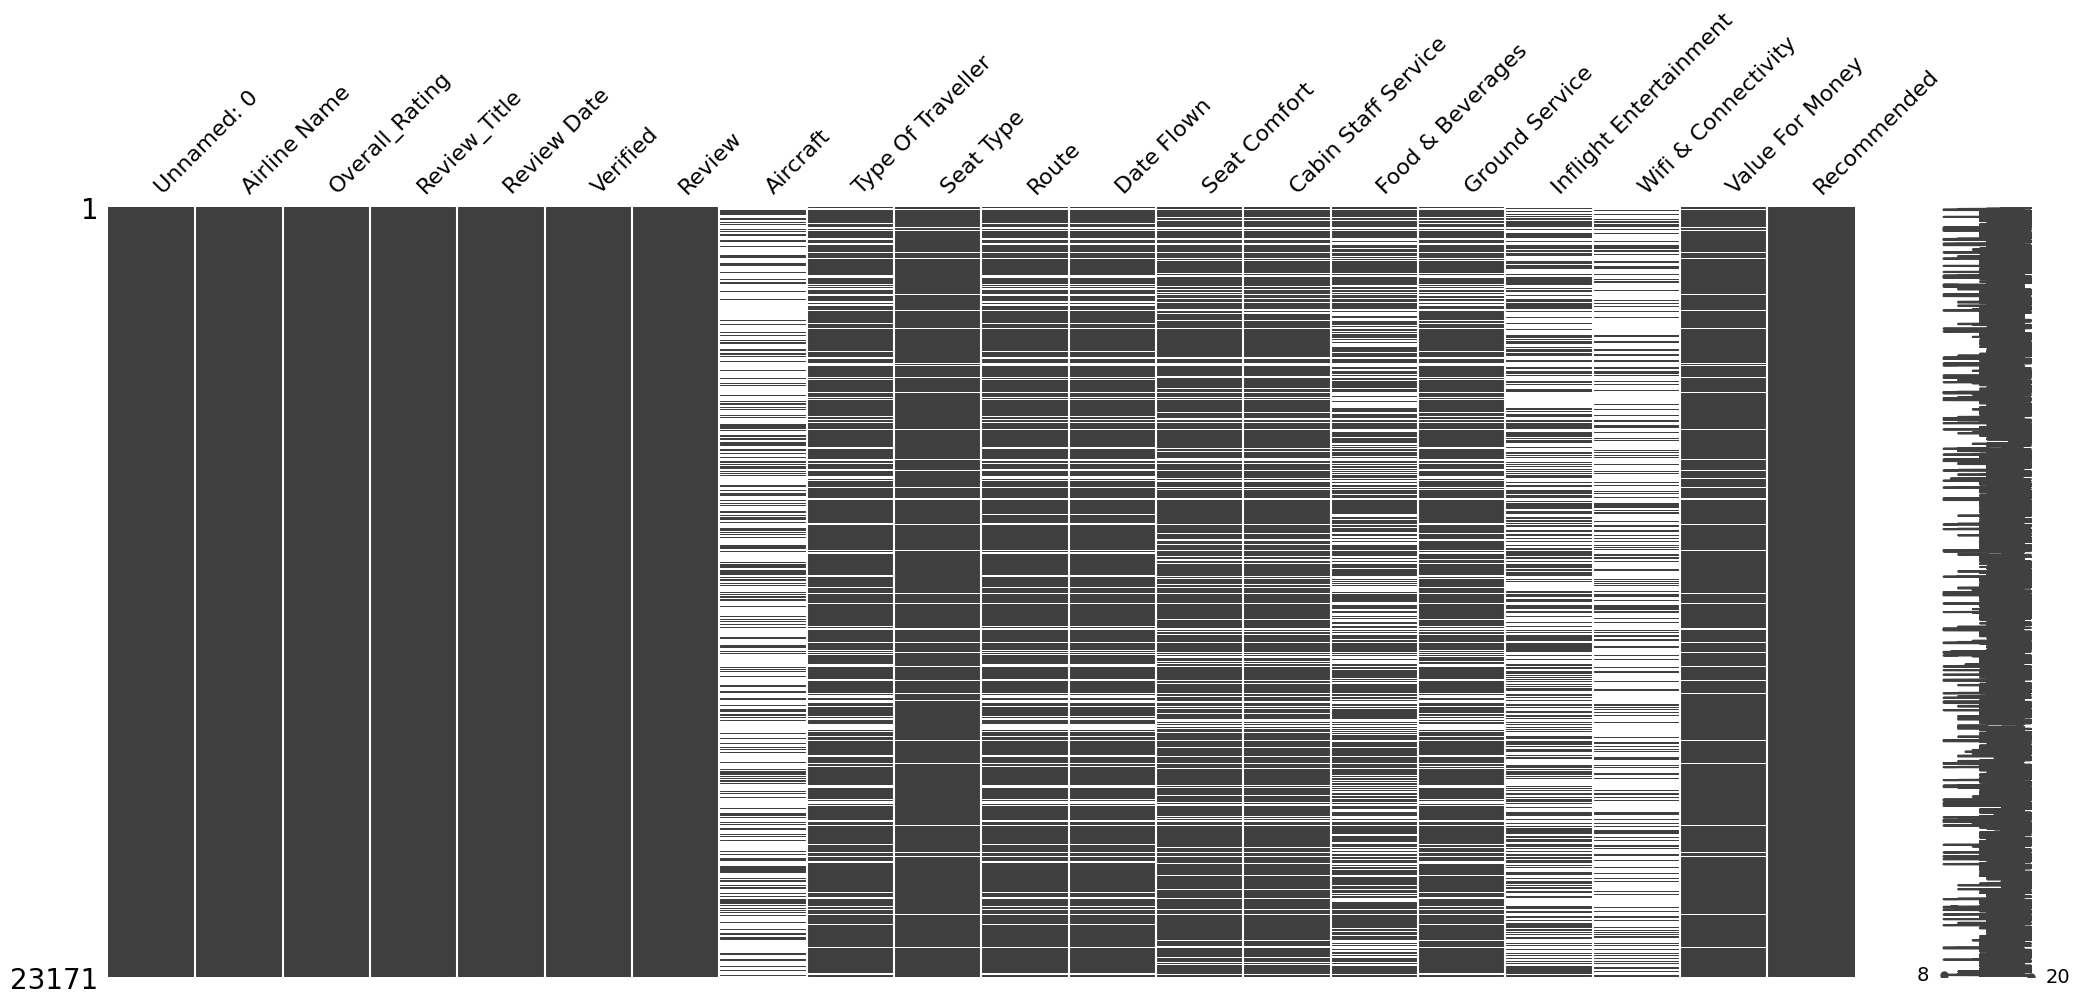

In [9]:
# Visualize the missing data
msno.matrix(df)

The columns `Seat Comfort` (4155 missing values), `Cabin Staff Service` (4260 missing values), `Food & Beverages` (8671 missing values), `Ground Service` (4793 missing values), `Inflight Entertainment` (12342 missing values), `Wifi & Connectivity` (17251 missing values), and `Value For Money` (1066 missing values) all represent ratings provided by reviewers.

These ratings are missing due to the discretionary nature of the reviews. Specifically, **reviewers may skip these fields** if they did not have a significant experience or do not prioritize these aspects of their flight. Therefore, the missing data in these columns can be considered **Missing Completely at Random (MCAR)**, as the decision to omit these ratings is not related to the actual ratings or the reviewers' overall experiences, but rather to random factors such as forgetfulness or disinterest.

Similarly, the columns `Aircraft`, `Type Of Traveller`, `Seat Type`, `Route`, and `Date Flown` have missing values that can be considered **Missing Completely at Random (MCAR)**. Reviewers might skip these fields based on random factors like forgetfulness or lack of knowledge, rather than any systematic issue related to the content or their overall review.

[Reference](https://medium.com/@ayeshasidhikha188/types-of-missing-values-fba155099ac7)

After identifying the missing value, the next step involves checking for any duplicate rows within the dataset using `duplicated().sum()` method.

In [10]:
# Check total of duplicated rows
df.duplicated().sum()

0

The result confirms that there are no duplicate rows present in the dataset.

Following that, the column names are reviewed to ensure consistency and accuracy.

In [11]:
# Check column names
df.columns

Index(['Unnamed: 0', 'Airline Name', 'Overall_Rating', 'Review_Title',
       'Review Date', 'Verified', 'Review', 'Aircraft', 'Type Of Traveller',
       'Seat Type', 'Route', 'Date Flown', 'Seat Comfort',
       'Cabin Staff Service', 'Food & Beverages', 'Ground Service',
       'Inflight Entertainment', 'Wifi & Connectivity', 'Value For Money',
       'Recommended'],
      dtype='object')

The column names are inconsistent; some use underscores `_` while others have spaces. Additionally, the character `&` should be replaced with `and` during the cleaning process for clarity. To ensure uniformity and ease of handling, all column names should be converted to **lowercase**.

Following that, the unique values in each column are examined using the `nunique()` method.

In [12]:
# Check total unique values
df.nunique()

Unnamed: 0                23171
Airline Name                497
Overall_Rating               10
Review_Title              17219
Review Date                4557
Verified                      2
Review                    23046
Aircraft                   1048
Type Of Traveller             4
Seat Type                     4
Route                     13607
Date Flown                  109
Seat Comfort                  6
Cabin Staff Service           6
Food & Beverages              6
Ground Service                5
Inflight Entertainment        6
Wifi & Connectivity           6
Value For Money               6
Recommended                   2
dtype: int64

The dataset displays diversity with 497 unique airline names, 6-level ratings in various columns, 17,219 distinct review titles, and 13,607 unique flight routes. `Verified` and `Recommended` columns each have 2 unique values, likely indicating verification status and recommendations by reviewers. These varied values offer a broad perspective on airline experiences and feedback within the dataset.

#### **ii. Data Cleaning**

In this section, the focus shifts to data cleaning based on the previous findings, including renaming column names and addressing missing values.

In [13]:
# Renaming column names
df.columns = (df.columns
              .str.lower()
              .str.replace(' ', '_')
              .str.replace('&', 'and'))

All column names have been converted to lowercase, spaces have been replaced with underscores `_`, and the character `&` has been replaced with `and` as part of the data cleaning process.

Given that the missing values follow a Missing Completely At Random (MCAR) pattern, dropping rows as a method for handling these values is not visible due to the **high percentage (> 5%) of missing data**. Deleting rows would lead to the loss of a substantial amount of important information.

As an alternative, the chosen approach for this analysis is to impute the missing values, allowing to fill in the gaps with reasonable estimates based on the available data.

[Reference](https://towardsdatascience.com/missing-data-cfd9dbfd11b7)

In [14]:
# Function to impute missing values
def impute_missing_values(df):
    for column in df.columns:

        # Numerical columns
        if df[column].dtype in ['float64', 'int64']:
            if skew(df[column].dropna()) > 0.5 or skew(df[column].dropna()) < -0.5:
                # Highly skewed
                median_value = df[column].median()
                df[column].fillna(median_value, inplace=True)
            else:
                # Normally distributed
                mean_value = df[column].mean()
                df[column].fillna(mean_value, inplace=True)

        # Categorical columns
        elif df[column].dtype == 'object':
            mode_value = df[column].mode()[0]
            df[column].fillna(mode_value, inplace=True)

# Impute missing values
impute_missing_values(df)

The missing values are imputed based on their columns and data characteristics. **Categorical** columns are imputed using their **mode**, which represents the most frequent value in the column. Numerical columns with a **normal distribution** are filled with the **mean**. On the other hand, numerical columns with a **skewed distribution** are filled with the **median**.

#### **iii. Data Checking**

After completing the cleaning process, the final step is to verify its success. This section will conduct a thorough review to ensure the data is now clean and ready for analysis.

In [15]:
# Check column names after handling
df.columns

Index(['unnamed:_0', 'airline_name', 'overall_rating', 'review_title',
       'review_date', 'verified', 'review', 'aircraft', 'type_of_traveller',
       'seat_type', 'route', 'date_flown', 'seat_comfort',
       'cabin_staff_service', 'food_and_beverages', 'ground_service',
       'inflight_entertainment', 'wifi_and_connectivity', 'value_for_money',
       'recommended'],
      dtype='object')

The column names are now uniform and follow the same pattern, indicating that the renaming process was successful.

In [16]:
# Check missing values after handling
df.isnull().sum()

unnamed:_0                0
airline_name              0
overall_rating            0
review_title              0
review_date               0
verified                  0
review                    0
aircraft                  0
type_of_traveller         0
seat_type                 0
route                     0
date_flown                0
seat_comfort              0
cabin_staff_service       0
food_and_beverages        0
ground_service            0
inflight_entertainment    0
wifi_and_connectivity     0
value_for_money           0
recommended               0
dtype: int64

Additionally, there are no longer any missing values, confirming that the imputation process was successful.

The cleaning process was successfully completed, and the data is now ready to be saved to a CSV file for use in the Recommendation System in the other notebook.

In [17]:
# Save to csv
df.to_csv('airline_review_cleaned.csv', index=False)

### **D. Exploratory Data Analysis**

After loading and cleaning the data, it is now ready for the next step. Before proceeding to data processing, the dataset will be explored using visualizations to gain a better understanding.

#### **i. Reviews Word Cloud**

The first step in exploration involves visualizing the words in all reviews, as well as in recommended and not recommended reviews, using Word Clouds.

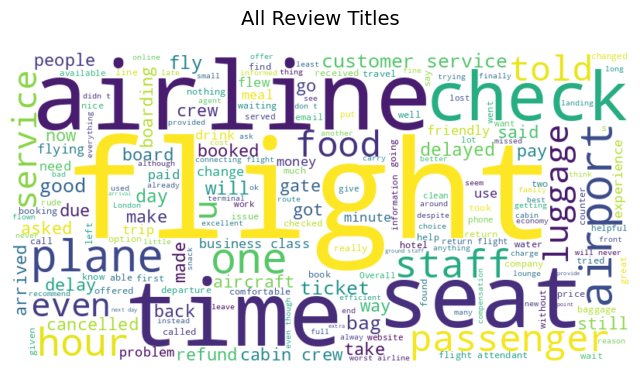

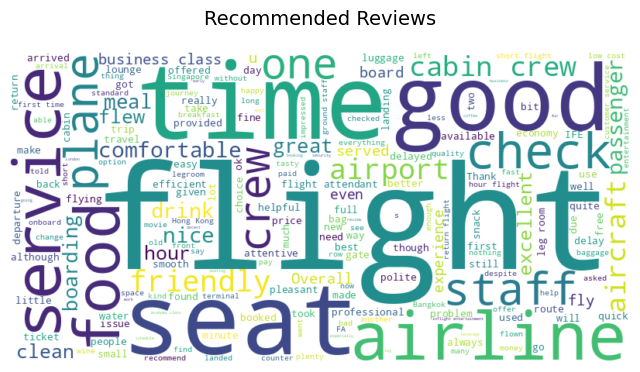

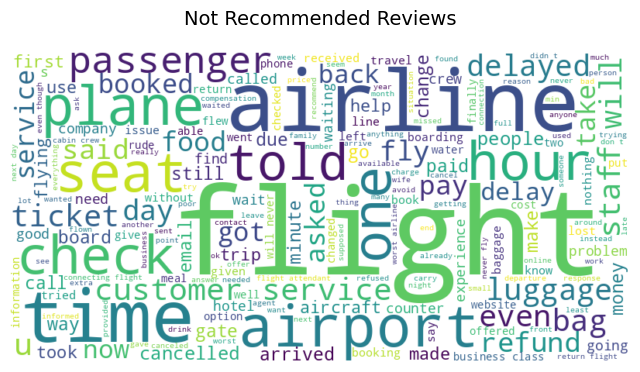

In [18]:
# Create function to generate word cloud
def generate_word_cloud(data, title, recommended):
    text = ' '.join(data['review'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    fig, ax = plt.subplots(figsize=(8, 16))
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.set_title(title, fontsize=14, pad=20)
    ax.axis("off")
    plt.show()

# Generate word cloud for all reviews
generate_word_cloud(df, 'All Review Titles', '')

# Generate word cloud for reviews with recommended = 'yes'
generate_word_cloud(df[df['recommended'] == 'yes'], 'Recommended Reviews', 'yes')

# Generate word cloud for reviews with recommended = 'no'
generate_word_cloud(df[df['recommended'] == 'no'], 'Not Recommended Reviews', 'no')

There are key insights from these word clouds:

- In the word cloud for all reviews, the most prominent words are `flight,` `airline,` `seat,` `time,` `check,` `plane,` and `staff.` These words suggest that passengers commonly discuss aspects of the flight itself, including timing and seating arrangements, as well as interactions with airline staff and the overall airline experience.

- In the word cloud for recommended reviews, the dominant words include `flight,` `seat,` `time,` `good,` `service,` `staff,` and `airline.` Positive reviews emphasize `good` and `service,` indicating that passengers who recommend the airline often appreciate the quality of service, the condition of seats, and the timely operation of flights.

- For not recommended reviews, the key words are `flight,` `check,` `time,` `seat,` `service,` `staff,` and `airport.` Negative reviews focus on issues such as the check-in process, waiting times, and customer service problems. The prominence of `check` and `time` indicates dissatisfaction with delays and the efficiency of airline operations.

In conclusion, the word clouds reveal common themes in passenger reviews, with positive reviews highlighting good service and overall satisfaction, while negative reviews focus on inefficiencies and poor service experiences. This analysis can help airlines identify areas for improvement and maintain strengths that contribute to positive customer feedback.

#### **ii. Verified User Distribution**

The next step is to examine the distribution of user reviews, specifically analyzing whether the reviewers are verified or not.

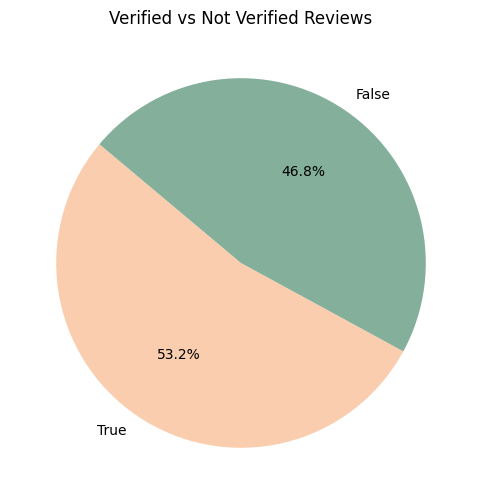

In [19]:
# Count number of verified and not verified reviews
verified_counts = df['verified'].value_counts()

# Plotting pie chart
plt.figure(figsize=(6, 6))
plt.pie(verified_counts, labels=verified_counts.index, autopct='%1.1f%%', startangle=140, colors=['#F9CDAD', '#83AF9B'])
plt.title('Verified vs Not Verified Reviews')
plt.show()

The pie chart illustrates that a slight majority of the reviews, **53.2%**, are from verified users, while **46.8%** are from non-verified users. This indicates a fairly balanced representation between verified and non-verified reviewers in the dataset.  Verified reviews can lend more credibility and trustworthiness to the dataset, potentially affecting the overall perceived reliability of the reviews and any conclusions drawn from them.

#### **iii. Type of Traveller Distribution**

After exploring the verification status of the reviews, the next step is to analyze the distribution of traveler types based on whether or not they recommend the airline.

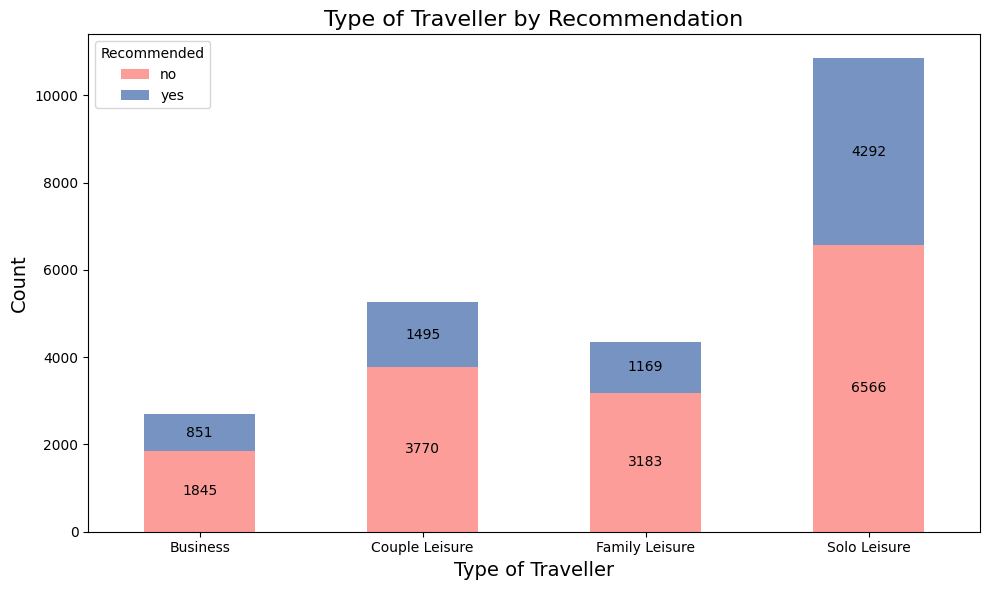

In [20]:
# Count the number of 'Type of Traveller' by 'Recommended' status
traveller_type_counts = df.groupby(['type_of_traveller', 'recommended']).size().unstack(fill_value=0)

# Plot stacked bar chart
ax = traveller_type_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#FC9D9A', '#7793C2'])

# Annotate the counts on top of each bar
for container in ax.containers:
    ax.bar_label(container, label_type='center')

plt.title('Type of Traveller by Recommendation', fontsize=16)
plt.xlabel('Type of Traveller', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=0)
plt.legend(title='Recommended')
plt.tight_layout()
plt.show()

From the stacked bar chart, **solo leisure travelers** have the highest overall count, with more negative recommendations (no) compared to positive ones (yes). **Couple leisure travelers** also have a significant number of reviews, with more negative feedback. **Family leisure travelers** have slightly more negative recommendations as well. Similarly, **business travelers**, though fewer in number, show more not recommended reviews. This suggests that the dataset contains many solo leisure travelers, and their reviews tend to not recommend the airline.

#### **iv. Seat Type Distribution**

Following the distribution of traveler types, it's crucial to explore seat preferences to gain deeper insights into passengers' needs and preferences.

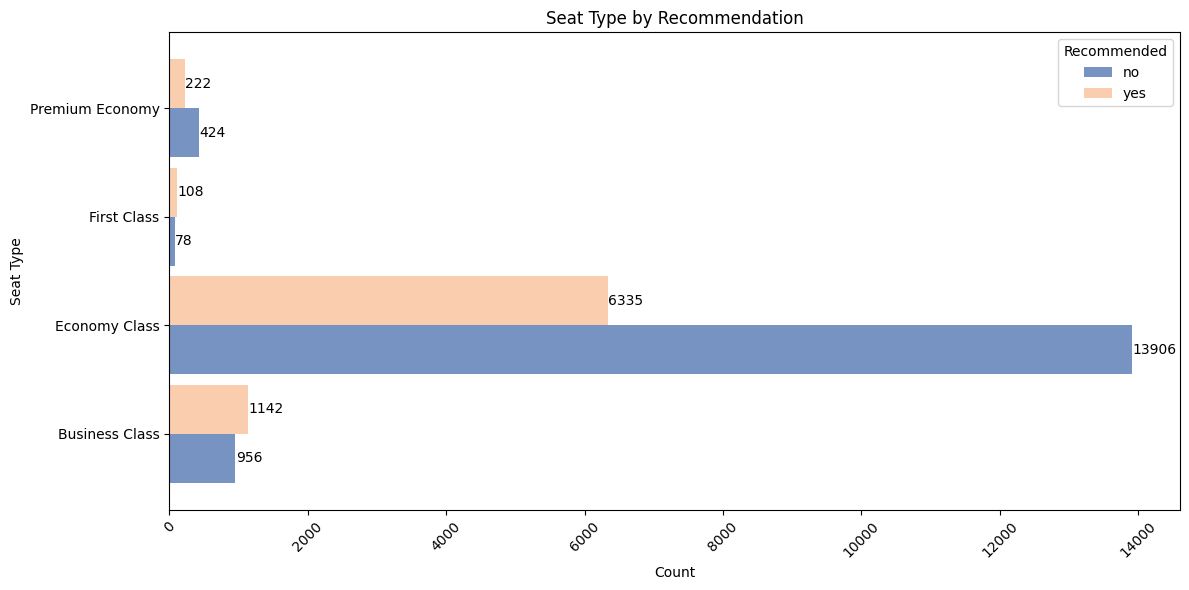

In [21]:
# Count the number of 'Seat Type' by 'Recommended' status
seat_type_counts = df.groupby(['seat_type', 'recommended']).size().unstack(fill_value=0)

# Create the grouped bar chart
ax = seat_type_counts.plot(kind='barh', width=0.9, figsize=(12, 6), color=['#7793C2', '#F9CDAD'])
plt.title('Seat Type by Recommendation')
plt.xlabel('Count')
plt.ylabel('Seat Type')
plt.legend(title='Recommended')
plt.xticks(rotation=45)
plt.tight_layout()

# Annotate the counts on the bars
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 3,
             p.get_y() + p.get_height() / 2,
             f'{width}',
             va='center')

plt.show()

The grouped bar chart illustrates varying satisfaction across airline seating classes. **Economy and Premium Economy** classes receive a high volume of feedback but also a substantial number of negative responses, suggesting that basic amenities and slight upgrades do not meet many travelers' expectations. In contrast, **First Class and Business Class**, despite fewer responses, have a higher proportion of positive recommendations, indicating satisfaction with the premium services offered. This shows that airlines face a challenge in meeting expectations, particularly in the more affordable seat categories.

#### **v. Rating Distribution**

There are several columns indicating the ratings of amenities provided by the airline. The next step in the analysis is to examine the distribution of these seven amenities to better understand passenger satisfaction with each.

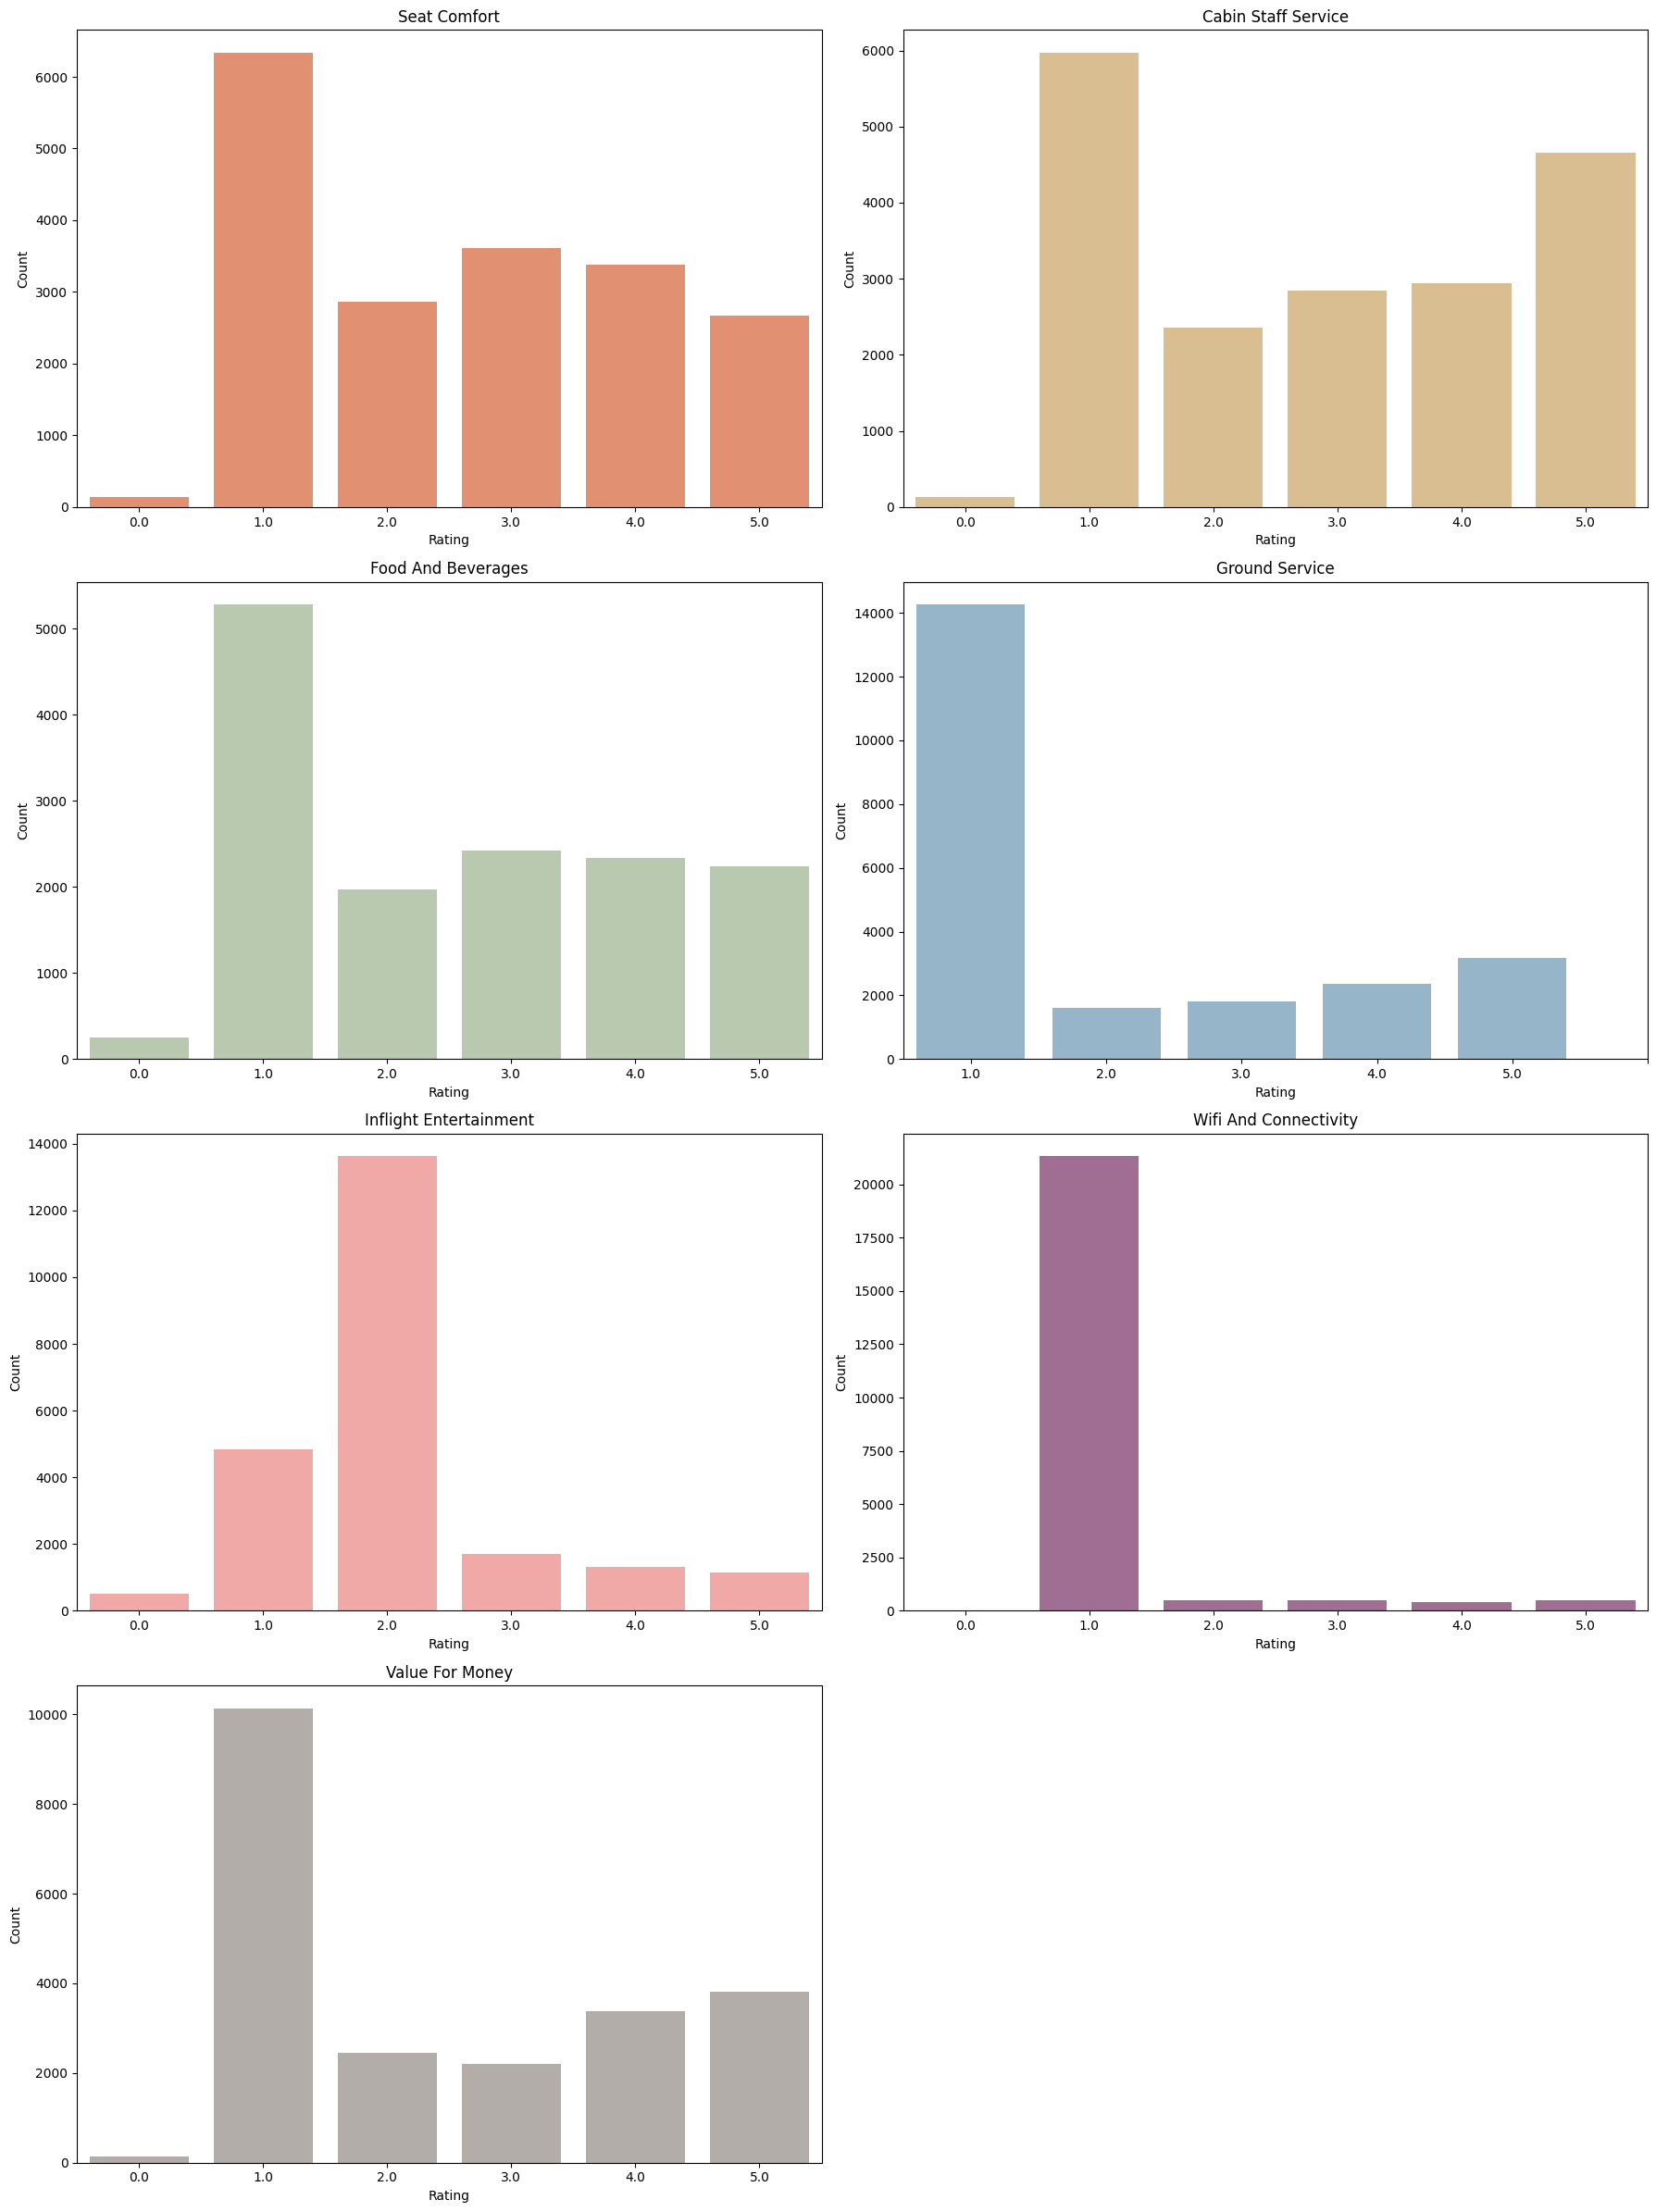

In [22]:
# Define the columns to visualize
columns_to_visualize = ['seat_comfort', 'cabin_staff_service', 'food_and_beverages', 'ground_service', 'inflight_entertainment',
                        'wifi_and_connectivity', 'value_for_money']

# Define individual colors for each plot
colors = ['#f4895f', '#e5c185', '#b8cdab', '#8db7d2', '#FC9D9A', '#a86498', '#b4ada6']

# Filter out invalid ratings
df_filtered = df[columns_to_visualize].applymap(lambda x: x if x in range(6) else None)

# Create subplots
fig, axes = plt.subplots(nrows=int((len(columns_to_visualize) + 1) / 2), ncols=2, figsize=(18, 24))
axes = axes.flatten()

for i, col in enumerate(columns_to_visualize):
    ax = axes[i]
    sns.countplot(x=df_filtered[col], ax=ax, color=colors[i])
    ax.set_title(col.replace('_', ' ').title())
    ax.set_xlabel('Rating')
    ax.set_ylabel('Count')
    ax.set_xticks(range(6))

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

The analysis of passenger ratings for various airline amenities shows:

- **Seat Comfort**: The highest frequency of ratings appears at 1.0, suggesting a lot of passengers find the seats uncomfortable. However, a significant number of reviews also gather around the 3.0 to 4.0 marks, indicating some level of satisfaction among other passengers.

- **Cabin Staff Service**: This category has pronounced peaks at both 1.0 and 5.0. It seems that passengers are divided, with many experiencing poor service while an equal number feel highly satisfied.

- **Food and Beverages**: The peak at 1.0 suggests widespread dissatisfaction with the food and beverages, though the distribution across other rating values is fairly even, indicating a mix of opinions.

- **Ground Service**: Ratings mostly start high at 1.0, with fewer complaints as the ratings go higher, showing that dissatisfaction is more common, but there is an upward trend towards satisfaction among fewer passengers.

- **Inflight Entertainment**: The peak at 2.0, closely followed by 1.0, suggests that the inflight entertainment does not generally meet passengers’ expectations, though it seems slightly more favorable than the lowest rating.

- **WiFi and Connectivity**: Dominantly, ratings are clustered at 1.0, with minimal higher ratings, highlighting a general dissatisfaction with internet services on flights.

- **Value for Money**: Most ratings cluster at 1.0, indicating a perception of poor value for money, yet there's a notable peak at 5.0 as well, suggesting that some passengers perceive great value.

These observations highlight specific areas where improvements could significantly enhance the passenger experience, particularly in seat comfort, WiFi connectivity, and the overall value for the cost of services.

#### **vi. Rating Correlation Analysis**

Once the distribution has been explored, the next step involves analyzing the heat map of the seven amenities to identify patterns and correlations in passenger satisfaction.

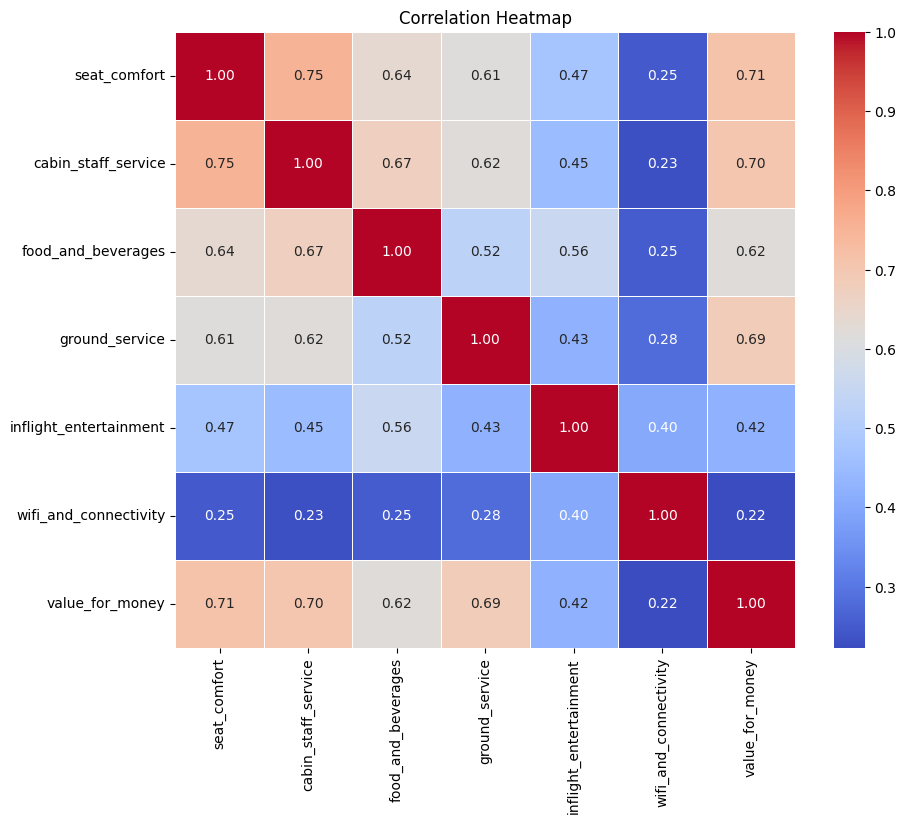

In [23]:
# List of columns to visualize
columns_to_visualize = ['seat_comfort', 'cabin_staff_service', 'food_and_beverages',
                        'ground_service', 'inflight_entertainment',
                        'wifi_and_connectivity', 'value_for_money']

# Filter the DataFrame to include only the columns to visualize
df_filtered = df[columns_to_visualize]

# Calculate the correlation matrix
correlation_matrix = df_filtered.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

The correlation heatmap reveals key relationships between different aspects of passenger satisfaction:

1. **Seat Comfort and Value for Money**: There's a strong positive correlation (0.71) between seat comfort and perceived value for money, indicating that comfortable seating significantly enhances passengers' perception of value.

2. **Service Categories**: Cabin staff service, food and beverages, and ground service show strong correlations (around 0.6 to 0.7) with each other, suggesting that satisfaction in one of these areas tends to align with satisfaction in the others.

3. **WiFi and Connectivity**: This shows weaker correlations (around 0.2 to 0.4) with other metrics, suggesting it has less impact on overall passenger satisfaction.

4. **Inflight Entertainment**: This has moderate influence, with some correlations to other services, indicating a contributing but not dominant role in overall satisfaction.

Overall, the heatmap suggests that focusing on improving seat comfort and integrated service quality could notably enhance overall passenger satisfaction.

#### **vii. Recommended Distribution**

Lastly, the recommended column is explored using a funnel chart to visualize the distribution of passenger recommendations.

In [24]:
# Create function to determine if the review is recommended based on the sentiment analysis
def get_recommended(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0.15:
        return 'Yes'
    else:
        return 'No'

# Apply the function to the 'Review' column
df['recommended'] = df['review'].apply(get_recommended)

# Count the number of each sentiment
recommendation_counts = df['recommended'].value_counts()

# Create the doughnut chart
fig = go.Figure(go.Pie(
    labels=recommendation_counts.index,
    values=recommendation_counts.values,
    hole=0.4,  # This creates the doughnut hole
    marker={'colors': ['#a86498', '#FC9D9A']}))

fig.update_layout(
    title={'text': 'Doughnut Chart by Recommendation', 'y': 0.9, 'x': 0.5, 'xanchor': 'center', 'yanchor': 'top'},
    width=600,
    height=400)

# Show the figure
fig.show()

The doughnut chart illustrates the distribution of recommendations based on airline reviews. Here, **66.5%** of passengers did not recommend the airline, while **33.5%** did. This visualization effectively highlights the challenge faced by the airline in improving passenger satisfaction, as a significant majority are currently not endorsing their services.

### **E. Feature Engineering**

This section focuses on pre-processing the data to prepare it for training the model, ensuring accuracy and consistency in the dataset.

#### **i. Text Pre-processing**

Before proceeding to model building, the data must first undergo pre-processing. This step includes removing unnecessary columns, eliminating stopwords, reducing words to their base or root form (stemming), and applying other text preprocessing techniques to ensure uniformity (such as converting to lowercase, removing whitespace, etc.).

In [25]:
# Read the cleaned csv
df1 = pd.read_csv('airline_review_cleaned.csv')

The cleaned data is reloaded, and for training the model, only the `review` and `recommended` columns are required. Thus, any unnecessary columns will be dropped.

In [26]:
# Drop unnecessary columns
df1.drop(['unnamed:_0','airline_name','overall_rating','review_title','review_date','verified','aircraft','type_of_traveller',
          'seat_type','route','date_flown','seat_comfort','cabin_staff_service','food_and_beverages','ground_service','inflight_entertainment',
          'wifi_and_connectivity','value_for_money'], axis = 1, inplace = True)

# Show the first 5 rows
df1.head()

,review,recommended
0,Moroni to Moheli. Turned out to be a pretty ...,yes
1,Moroni to Anjouan. It is a very small airline...,no
2,Anjouan to Dzaoudzi. A very small airline an...,no
3,Please do a favor yourself and do not fly wi...,no
4,Do not book a flight with this airline! My fr...,no


The other columns are successfully dropped. The next step is to define the stopwords. To identify these, the 50 most common or frequent words will be displayed below.

In [27]:
# Show the most frequent words
df1['review_list'] = df1['review'].apply(lambda x:str(x).split())
high_all = Counter([item for sublist in df1['review_list'] for item in sublist])
tweet_high_all = pd.DataFrame(high_all.most_common(50))
tweet_high_all.columns = ['Words','Count']
tweet_high_all.style.background_gradient(cmap='Greens')

,Words,Count
0,the,121219
1,to,108401
2,and,88892
3,I,61967
4,was,59293
5,a,58474
6,in,38718
7,of,37158
8,for,36122
9,on,32089


After identifying the most frequent words, the stopwords will be updated to include these custom stopwords so that they can be effectively removed during text pre-processing.

In [28]:
# Define Stopwords
stpwds_id = list(set(stopwords.words('english')))

# Add custom stopwords
custom_stopwords = ['the', 'to', 'and', 'I', 'was', 'a', 'in', 'of', ' for', 'on', 'flight', 'with', 'that', 'my', 'is', 'not', 'were', 'they',
                    'The', 'at', 'we', 'had', 'from', 'but', 'have', 'it', 'this', 'no', 'as', 'me', 'you', 'our', 'be', 'are', 'an', 'very', 'so',
                    'service', 'their', 'We', 'time','airline', 'would', 'or', 'us', 'by', 'only', 'get', 'all' 'which']

# Extend the stopwords
stpwds_id.extend(custom_stopwords)

The stopwords are extended using the defined custom stopwords. Next, the words need to be converted to their root form. For example, `flying` will be changed to its original form, `fly`. This reduces the number of unique words, making the text more efficient to process. This process, known as **stemming**, can be performed using a function called `PorterStemmer`.

In [29]:
# Define Stemming
stemmer = PorterStemmer()

After extending the stopwords and defining the stemmer, the next step is to create a function that performs the overall text preprocessing.

In [30]:
# Create A Function for Text Preprocessing
def text_preprocessing(text):

    # Case folding
    text = text.lower()

    # Mention removal
    text = re.sub(r'https?://(?:www\.[^\s\n\r]+|[^\s\n\r]+)', '', text)

    # Hashtags removal
    text = re.sub(r'#', '', text)

    # Newline removal (\n)
    text = re.sub(r'[\n\r]', '', text)

    # Replaces the numbers with an empty string
    text = re.sub(r'\d+', '', text)

    # Whitespace removal
    text = text.strip()

    # URL removal
    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"www.\S+", " ", text)

    # Non-letter removal (such as emoticon, symbol (like μ, $, 兀), etc.)
    text = re.sub("[^A-Za-z\s']", " ", text)

    # Tokenization
    tokens = word_tokenize(text)

    # Stopwords removal
    tokens = [word for word in tokens if word not in stpwds_id]

    # Stemming
    tokens = [stemmer.stem(word) for word in tokens]

    # Combining Tokens
    text = ' '.join(tokens)

    return text

The function `text_preprocessing` performs several text preprocessing steps to clean and prepare text data for analysis. Here's an overview of what each step does:

- **Case Folding**: Converts all text to lowercase to ensure uniformity.
- **Mention Removal**: Removes mentions of websites or social media handles (URLs).
- **Hashtags Removal**: Eliminates hashtags from the text.
- **Newline Removal**: Removes newline characters (\n) from the text.
- **Number Removal**: Replaces numerical digits with an empty string.
- **Whitespace Removal**: Strips leading and trailing whitespace.
- **URL Removal**: Removes URLs and website addresses from the text.
- **Non-Letter Removal**: Removes non-alphabetic characters (emoticons, symbols, etc.).
- **Tokenization**: Splits the text into individual words or tokens.
- **Stopwords Removal**: Removes common stopwords from the tokens.
- **Stemming**: Converts words to their base or root form using the Porter Stemmer.
- **Combining Tokens**: Joins the processed tokens back into a single text string.

This function is designed to clean text data suitable for natural language processing (NLP) tasks, such as this sentiment analysis.


The function is then applied to the DataFrame by creating a new column called `review_cleaned`, which will contain the preprocessed and cleaned text data.

In [31]:
# Applying Text Preprocessing to the Dataset
df1['review_cleaned'] = df1['review'].apply(lambda x: text_preprocessing(x))

# Show the first 5 rows
df1.head()

,review,recommended,review_list,review_cleaned
0,Moroni to Moheli. Turned out to be a pretty ...,yes,"[Moroni, to, Moheli., Turned, out, to, be, a, ...",moroni mohe turn pretti decent onlin book work...
1,Moroni to Anjouan. It is a very small airline...,no,"[Moroni, to, Anjouan., It, is, a, very, small,...",moroni anjouan small ticket advis turn hr conf...
2,Anjouan to Dzaoudzi. A very small airline an...,no,"[Anjouan, to, Dzaoudzi., A, very, small, airli...",anjouan dzaoudzi small base comoro check disor...
3,Please do a favor yourself and do not fly wi...,no,"[Please, do, a, favor, yourself, and, do, not,...",pleas favor fli adria rout munich pristina jul...
4,Do not book a flight with this airline! My fr...,no,"[Do, not, book, a, flight, with, this, airline...",book friend return sofia amsterdam septemb day...


The function is successfully applied to the DataFrame, as seen on the new column `review_cleaned` with the processed and cleaned text data.

#### **ii. Target Conversion**

The target label, `recommended`, will be converted to numerical values as machine learning models cannot directly process words. Specifically, `yes` will be assigned a value of `1`, while `no` will be assigned a value of `0`.

In [32]:
# Convert target column into number
df1['label'] = df1['recommended'].replace({'no' : 0, 'yes' : 1})

df1.head()

,review,recommended,review_list,review_cleaned,label
0,Moroni to Moheli. Turned out to be a pretty ...,yes,"[Moroni, to, Moheli., Turned, out, to, be, a, ...",moroni mohe turn pretti decent onlin book work...,1
1,Moroni to Anjouan. It is a very small airline...,no,"[Moroni, to, Anjouan., It, is, a, very, small,...",moroni anjouan small ticket advis turn hr conf...,0
2,Anjouan to Dzaoudzi. A very small airline an...,no,"[Anjouan, to, Dzaoudzi., A, very, small, airli...",anjouan dzaoudzi small base comoro check disor...,0
3,Please do a favor yourself and do not fly wi...,no,"[Please, do, a, favor, yourself, and, do, not,...",pleas favor fli adria rout munich pristina jul...,0
4,Do not book a flight with this airline! My fr...,no,"[Do, not, book, a, flight, with, this, airline...",book friend return sofia amsterdam septemb day...,0


The `recommended` column now only contains numerical values, specifically `0` and `1`.

The values in the column are counted to ensure the successful conversion, tallying the occurrences of both `0` and `1`.

In [33]:
# Target Distribution
df1['label'].value_counts()

label
0    15364
1     7807
Name: count, dtype: int64

The column has been successfully converted, with **15,364** instances of `0` (representing `No`) and **7,807** instances of `1` (representing `Yes`).

#### **iii. Data Splitting**

After converting the target label, the data is now split into `X` and `y`, representing the features and target variable, respectively, for training.

In [34]:
# Splitting between `X` and `y`
X = df1.drop('recommended', axis=1)
y = df1['recommended']

The `X` variable contains the reviews, while the `y` variable contains the values from the `recommended` column.

Now, the data is split into three sets: `training`, `validation`, and `testing`. This separation is important because:

1. **Training Set**: This set is used for training the machine learning model. The model learns patterns and relationships from this data.

2. **Validation Set**: This set is used for fine-tuning the model and selecting the best hyperparameters. It helps in assessing the model's performance on unseen data and prevents overfitting.

3. **Testing Set**: This set is used for evaluating the final performance of the trained model. It provides an unbiased estimate of the model's performance on new, unseen data.

In [35]:
# Data Splitting
X_train_val, X_test, y_train_val, y_test = train_test_split(df1.review_cleaned,
                                                    df1.label,
                                                    test_size=0.15,
                                                    random_state=20,
                                                    stratify=df1.label)

X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=0.10,
                                                  random_state=20,
                                                  stratify=y_train_val)

# Print the shapes
print('Train Size : ', X_train.shape)
print('Val Size   : ', X_val.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (17725,)
Val Size   :  (1970,)
Test Size  :  (3476,)


The data is split into two sets initially: `train_val` (**85%**) and `test` (**15%**). Next, the `train_val` set is further divided into `train` (**90%**) and `val` (**10%**).

Following that, all entries in the `y` variable are encoded using One-Hot Encoding via the `to_categorical` function.

In [36]:
# Change Target to One Hot Encoding
y_train_ohe = to_categorical(y_train)
y_val_ohe = to_categorical(y_val)
y_test_ohe = to_categorical(y_test)

# Display one example
y_train_ohe

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

The array represents binary encoding after applying One-Hot Encoding to the target variable. Each row corresponds to a sample, with the first column indicating a negative recommendation (0) and the second column indicating a positive recommendation (1).

#### **iv. Missing Value Handling**

Since the previous step handled missing values using an imputer, this section only checks whether all variables have no missing values.

In [37]:
# Check missing values for X_train
X_train.isnull().sum()

0

In [38]:
# Check missing values for X_val
X_val.isnull().sum()

0

In [39]:
# Check missing values for X_test
X_test.isnull().sum()

0

In [40]:
# Check missing values for y_train
y_train.isnull().sum()

0

In [41]:
# Check missing values for y_val
y_val.isnull().sum()

0

In [42]:
# Check missing values for y_test
y_test.isnull().sum()

0

The results indicate that all six variables **do not** contain any missing values, allowing to proceed to the next step.

#### **v. Text Vectorization**

Since text data cannot be directly processed by machine learning algorithms, all of the text needs to be **vectorized** or transformed into numerical representations for further analysis.

In [43]:
# Define vectorizer
Vectorize = CountVectorizer()

# Apply vectorization to X_train and X_test
X_train_vec = Vectorize.fit_transform(X_train)
X_test_vec = Vectorize.transform(X_test)

This code defines a CountVectorizer object to convert text into numerical vectors. The fit_transform method is applied to the training data `X_train`, while the transform method is used for the testing data `X_test`. The resulting vectors represent the frequency of each word in the text.

After vectorization, the total number of unique words (vocabulary) and the maximum length of a tokenized sentence in the training data are calculated. Counting the number of different words and determining the longest sentence helps in setting up the following steps.

In [44]:
# Calculating number of vocabs and max token length
total_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print('Total Vocab : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

Total Vocab :  18426
Maximum Sentence Length :  515 tokens


The total vocabulary after vectorization is **18,426** words, and the maximum sentence length in the training data is **515** tokens.

Following that, the TextVectorization function is used to prepare the text for computer models, adjusting settings to ensure smooth operation.

In [45]:
# Parameters for TextVectorization
text_vectorization = TextVectorization(max_tokens=total_vocab,
                                       standardize='lower_and_strip_punctuation',
                                       split='whitespace',
                                       ngrams=None,
                                       output_mode='int',
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,))

# Apply to X_train
text_vectorization.adapt(X_train)

The code sets up a TextVectorization layer to process text data for machine learning, adapting it to the training data by defining how text is tokenized, standardized, and formatted for model input.

In [46]:
# Document example
print('Document example')
print(df1.review_cleaned[0])
print('')

# Result of Text Vectorization
print('Result of Text Vectorization')
print(text_vectorization([df1.review_cleaned[0]]))
print('Vector size : ', text_vectorization([df1.review_cleaned[0]]).shape)

Document example
moroni mohe turn pretti decent onlin book work well checkin board fine plane look well maintain short minut n't expect much still manag hand bottl water biscuit though nice flight

Result of Text Vectorization
tf.Tensor(
[[ 8312 14525   337   368   489   149    14    88    92   970     7   255
     12   144    92   958   155    42     5   162   108    73   195   216
    548   126  1506   156   114    13     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0   

The text has been turned into a long list of numbers, where each number represents a word from the original text. The list is shaped like a table with one row and 515 columns. This transformation helps computers understand and work with the text more effectively for tasks like analyzing sentiment or categorizing topics.

In [47]:
# View the Top 20 Tokens (Sorted by the Highest Frequency of Appearance)
text_vectorization.get_vocabulary()[:20]

['',
 '[UNK]',
 'seat',
 'hour',
 'check',
 'nt',
 'fli',
 'board',
 'one',
 'delay',
 'airport',
 'staff',
 'plane',
 'flight',
 'book',
 'custom',
 'crew',
 'good',
 'air',
 'even']

These are the top 20 tokens (words) from the text data, sorted by their frequency of appearance.

#### **vi. Word Embedding**

**Word embedding** represents words as continuous vectors in a space where similar words are closer together. This method captures semantic relationships between words, unlike simpler methods like one-hot encoding. The next step is to apply word embedding to convert text tokens into dense, meaningful vectors for better processing and analysis.

In [48]:
# Define embedding
embedding = Embedding(input_dim=total_vocab,
                      output_dim=128,
                      embeddings_initializer='uniform',
                      input_length=max_sen_len)

An embedding layer is created that converts words into 128-dimensional vectors, initializing the vectors uniformly, and uses the total number of unique words and the maximum sentence length as parameters.

The next step is to apply text vectorization and embedding to the cleaned review, demonstrating the transformation of text into numerical vectors and their subsequent embedding.

In [49]:
# Document example
print('Document example')
print(df1.review_cleaned[0])
print('')

# Result of Text Vectorization
print('Result of  Text Vectorization')
print(text_vectorization([df1.review_cleaned[0]]))
print('Vector size : ', text_vectorization([df1.review_cleaned[0]]).shape)
print('')

# Result of  Embedding
print('Result of  Embedding')
print(embedding(text_vectorization([df1.review_cleaned[0]])))
print('Vector size : ', embedding(text_vectorization([df1.review_cleaned[0]])).shape)

Document example
moroni mohe turn pretti decent onlin book work well checkin board fine plane look well maintain short minut n't expect much still manag hand bottl water biscuit though nice flight

Result of  Text Vectorization
tf.Tensor(
[[ 8312 14525   337   368   489   149    14    88    92   970     7   255
     12   144    92   958   155    42     5   162   108    73   195   216
    548   126  1506   156   114    13     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0  

The text vectorization result is a 515-dimensional representation of the review's main points.

Meanwhile, the embedding result turns each word into a 128-dimensional vector, capturing word meanings and helping the model understand the review better.

These transformations make it easier for machine learning models to analyze and understand the review's content.

### **F. Model Development**

After preprocessing the data, the next step involves building two models for sentiment analysis on airline reviews: LSTM (Long Short Term Memory) and Logistic Regression. 

- **LSTM (Long Short Term Memory)**:
  - LSTM is a type of recurrent neural network (RNN) designed to process sequences of data.
  - LSTM is chosen for its ability to process sequential data, making it ideal for tasks like sentiment analysis on text data. It can capture long-term dependencies, crucial in understanding sentiment nuances in reviews.
  - The metric used for evaluation is accuracy, as it provides a clear measure of how well the model predicts sentiment labels (positive or negative) correctly, which is essential for sentiment analysis tasks.

- **Logistic Regression**:
  - Logistic Regression is a statistical model used for binary classification tasks.
  - Logistic Regression serves as a baseline model for comparison, offering simplicity and effectiveness in binary classification tasks.
  - While LSTM captures sequential dependencies, Logistic Regression provides insights into feature importance and linear decision boundaries, aiding interpretability.
  - Accuracy is again used as the metric for model evaluation, ensuring consistent comparison between the two models based on their predictive performance in sentiment classification.

The choice of accuracy as the evaluation metric is suitable for sentiment analysis as it directly measures the model's ability to correctly predict sentiment labels, aligning with the primary objective of understanding customer sentiment from airline reviews.

[Reference 1](https://www.geeksforgeeks.org/deep-learning-introduction-to-long-short-term-memory/)  
[Reference 2](https://www.geeksforgeeks.org/understanding-logistic-regression/)

In each stage of model development, there are three critical steps: model definition, model training, and model evaluation. Here's a breakdown of each step:

1. **Model Definition** : Design the model architecture, specifying layers, activation functions, optimizer, and loss function to create a blueprint for the model.
2. **Model Training** : Train the model using the defined architecture with the training dataset and validate it with the validation dataset.
3. **Model Evalutaion** : Evaluate the model's performance using metrics, ensure its generalization ability through validation, understand its decision-making process for interpretability, and compare it with other models.

#### **1. LSTM**

##### **i. Model Definition**

The LSTM model will use a Keras embedding layer as part of its neural network architecture for this NLP tasks. This embedding layer will either be added as the initial layer in a Sequential model or integrated into a custom model architecture. The process starts with downloading the layer.

In [50]:
# Download the Embedding Layer
url = 'https://tfhub.dev/google/tf2-preview/nnlm-id-dim128-with-normalization/1'
hub_layer = tf_hub.KerasLayer(url, output_shape=[128], input_shape=[], dtype=tf.string)

The embedding layer is successfully downloaded using the provided URL from TensorFlow Hub. This layer is configured with an output shape of 128 dimensions and expects input as strings. The model can proceed to building the model using LSTM.

In [51]:
# Clear Session
seed = 20
tf.keras.backend.clear_session()
tf.random.set_seed(seed)

In [52]:
# Define the architecture
model_lstm = Sequential()

# Add embedding layer
model_lstm.add(hub_layer)

# Reshape the input
model_lstm.add(Reshape((128, 1)))

# First Bidirectional LSTM layer
model_lstm.add(Bidirectional(LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm.add(Dropout(0.1))

# Second Bidirectional LSTM layer
model_lstm.add(Bidirectional(LSTM(16, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm.add(Dropout(0.1))

# Output layer
model_lstm.add(Dense(2, activation='sigmoid'))

# Compile the model
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')

# Print the model summary
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               112461824 
                                                                 
 reshape (Reshape)           (None, 128, 1)            0         
                                                                 
 bidirectional (Bidirection  (None, 128, 64)           8704      
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 128, 64)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 32)                0

The model architecture uses a pre-trained embedding layer from TensorFlow Hub, reshaping input to (128, 1). Two **Bidirectional** LSTM layers follow, the first with **32** units and return sequences, the second with **16** units, both using a **dropout** rate of **0.1**. A dense layer with **2** units and a **sigmoid** activation function serves for binary classification (`yes` or `no`).

The model is compiled with binary cross-entropy loss, the Adam optimizer, and accuracy as a metric. The summary provides detailed layer configurations and parameter counts, totaling **112,480,962** parameters.

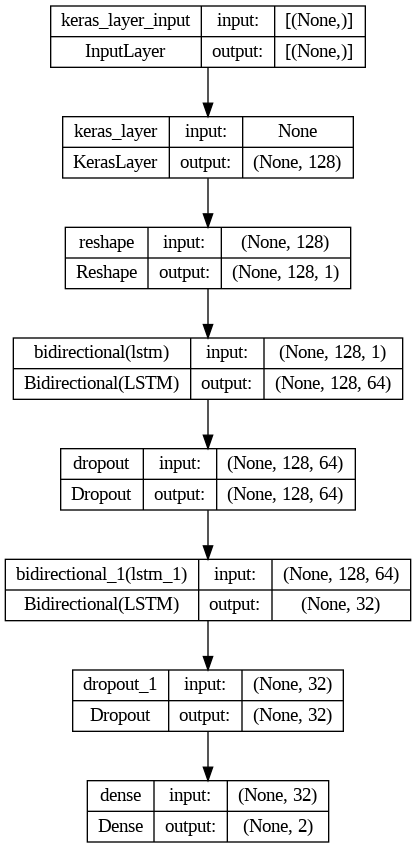

In [53]:
# Plot Layers
tf.keras.utils.plot_model(model_lstm, show_shapes=True)

For clearer visualization and easier understanding, the diagram illustrates the LSTM model architecture as previously explained.

##### **ii. Model Training**

After defining the model architecture, the next step is to train the model. Two callbacks are used in this analysis: **EarlyStopping** and **LearningRateScheduler**.

- **EarlyStopping**: This callback monitors the model's performance on the validation set and stops training when the performance stops improving. This helps in preventing overfitting and reduces unnecessary training time.
- **LearningRateScheduler**: This callback adjusts the learning rate during training according to a predefined schedule, which can help in achieving better convergence and avoiding local minima.

In [54]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define Learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

The **EarlyStopping** callback monitors the validation loss during training. If the validation loss does not improve for **10** consecutive epochs, training will stop early. Additionally, the model will restore the weights from the epoch with the best validation loss, ensuring the best performance on the validation set.

The **LearningRateScheduler** callback adjusts the learning rate based on the current epoch. For the first 10 epochs, it keeps the learning rate constant. After 10 epochs, it decreases the learning rate exponentially, which helps in fine-tuning the model and achieving better convergence. This gradual reduction can prevent the model from overshooting the optimal solution and improve stability during training.

The model can now be trained using `model_lstm` for 50 epochs. The validation set is used for validation to monitor the model's performance and apply the EarlyStopping and LearningRateScheduler callbacks effectively.

In [55]:
# Training with LSTM model
%%time
model_lstm_hist = model_lstm.fit(X_train, y_train_ohe, epochs=50, validation_data=(X_val, y_val_ohe))

Epoch 1/50
554/554 [==============================] - 102s 166ms/step - loss: 0.6038 - accuracy: 0.6735 - val_loss: 0.5926 - val_accuracy: 0.6777
Epoch 2/50
554/554 [==============================] - 108s 196ms/step - loss: 0.5554 - accuracy: 0.7051 - val_loss: 0.5281 - val_accuracy: 0.7401
Epoch 3/50
554/554 [==============================] - 85s 154ms/step - loss: 0.5363 - accuracy: 0.7207 - val_loss: 0.5184 - val_accuracy: 0.7406
Epoch 4/50
554/554 [==============================] - 85s 154ms/step - loss: 0.5246 - accuracy: 0.7320 - val_loss: 0.5029 - val_accuracy: 0.7442
Epoch 5/50
554/554 [==============================] - 94s 169ms/step - loss: 0.5178 - accuracy: 0.7399 - val_loss: 0.5041 - val_accuracy: 0.7437
Epoch 6/50
554/554 [==============================] - 85s 154ms/step - loss: 0.5128 - accuracy: 0.7432 - val_loss: 0.5016 - val_accuracy: 0.7482
Epoch 7/50
554/554 [==============================] - 98s 177ms/step - loss: 0.5109 - accuracy: 0.7442 - val_loss: 0.5014 - val_

The training process ran for **50** epochs, and it took approximately **1 hour 51 minutes 2 seconds** to complete. The last saved scores for the model were a training loss of **0.3991**, training accuracy of **0.8142**, validation loss of **0.4070**, and validation accuracy of **0.8157**.

These accuracy scores suggest that the model performs **well**, fitting the training data effectively and generalizing well to unseen data. However, the training process was **time-consuming**.

##### **iii. Model Evaluation**

The model is evaluated through three methods: **visualizing** the training process, generating a **classification report** for both the training and testing sets, and creating **confusion matrices** for both sets.

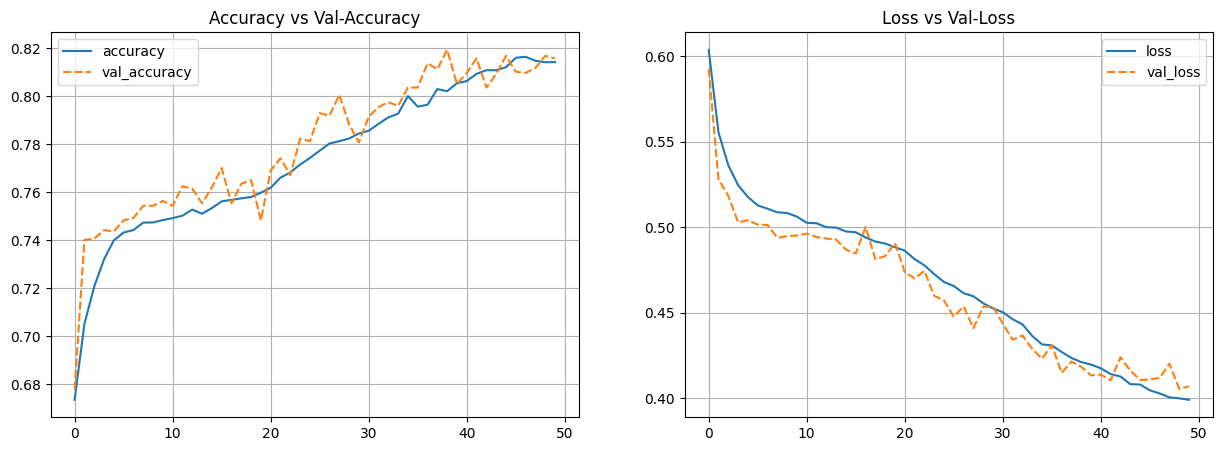

In [56]:
# Plot Training Results
model_lstm_hist_df = pd.DataFrame(model_lstm_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

The visualization display the training and validation accuracy and loss over 50 epochs for the LSTM model:

1. **Accuracy vs Val-Accuracy**: Both training and validation accuracy increase over time, demonstrating that the model is learning effectively. The training accuracy is consistently higher than the validation accuracy, which is typical due to the model being optimized on training data. However, the validation accuracy closely follows the training accuracy, indicating good generalization to unseen data.

2. **Loss vs Val-Loss**: The loss for both training and validation decreases significantly in the initial epochs and continues to decrease at a slower rate. The training loss is lower than the validation loss throughout, which is expected. The patterns of the curves are stable after the initial drop, with minor fluctuations towards the end, suggesting that the model is reaching a stable state of learning.

Overall, the model shows promising learning characteristics with consistent improvements in accuracy and reductions in loss, indicating effective learning and generalization capabilities. There are no signs of significant overfitting, as the validation metrics follow the training metrics closely.

In [57]:
# Predict probabilities for each class in training set
y_pred_train_probs_lstm = model_lstm.predict(X_train)

# Get the predicted class labels (argmax along the last axis)
y_pred_train_lstm = np.argmax(y_pred_train_probs_lstm, axis=1)

# Classification report
print(classification_report(y_train, y_pred_train_lstm))

554/554 [==============================] - 23s 38ms/step
              precision    recall  f1-score   support

           0       0.88      0.85      0.86     11753
           1       0.72      0.78      0.75      5972

    accuracy                           0.82     17725
   macro avg       0.80      0.81      0.81     17725
weighted avg       0.83      0.82      0.82     17725



In [58]:
# Predict probabilities for each class in testing set
y_pred_test_probs_lstm = model_lstm.predict(X_test)

# Get the predicted class labels (argmax along the last axis)
y_pred_test_lstm = np.argmax(y_pred_test_probs_lstm, axis=1)

# Classification report
print(classification_report(y_test, y_pred_test_lstm))

109/109 [==============================] - 4s 32ms/step
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      2305
           1       0.68      0.72      0.70      1171

    accuracy                           0.79      3476
   macro avg       0.77      0.78      0.77      3476
weighted avg       0.80      0.79      0.79      3476



The model's performance metrics on both training and test data indicate robust classification capabilities, with minor differences observed between the two datasets.

- **Training Data Performance**:
  - The model exhibits strong classification abilities during training, achieving an accuracy of 82%. It particularly excels in accurately identifying the majority class, showcasing high precision and recall scores. Furthermore, it maintains decent performance for the minority class.

- **Test Data Performance**:
  - On the test dataset, the model's accuracy slightly decreases to 79%. Despite this minor drop, it still performs well for both classes, although precision and recall show a slight decline compared to the training phase. This indicates that while the model generalizes effectively to new data, there may be some overfitting or disparities between the training and test datasets.

In summary, the model effectively classifies two distinct classes, although there may be some overfitting concerns.

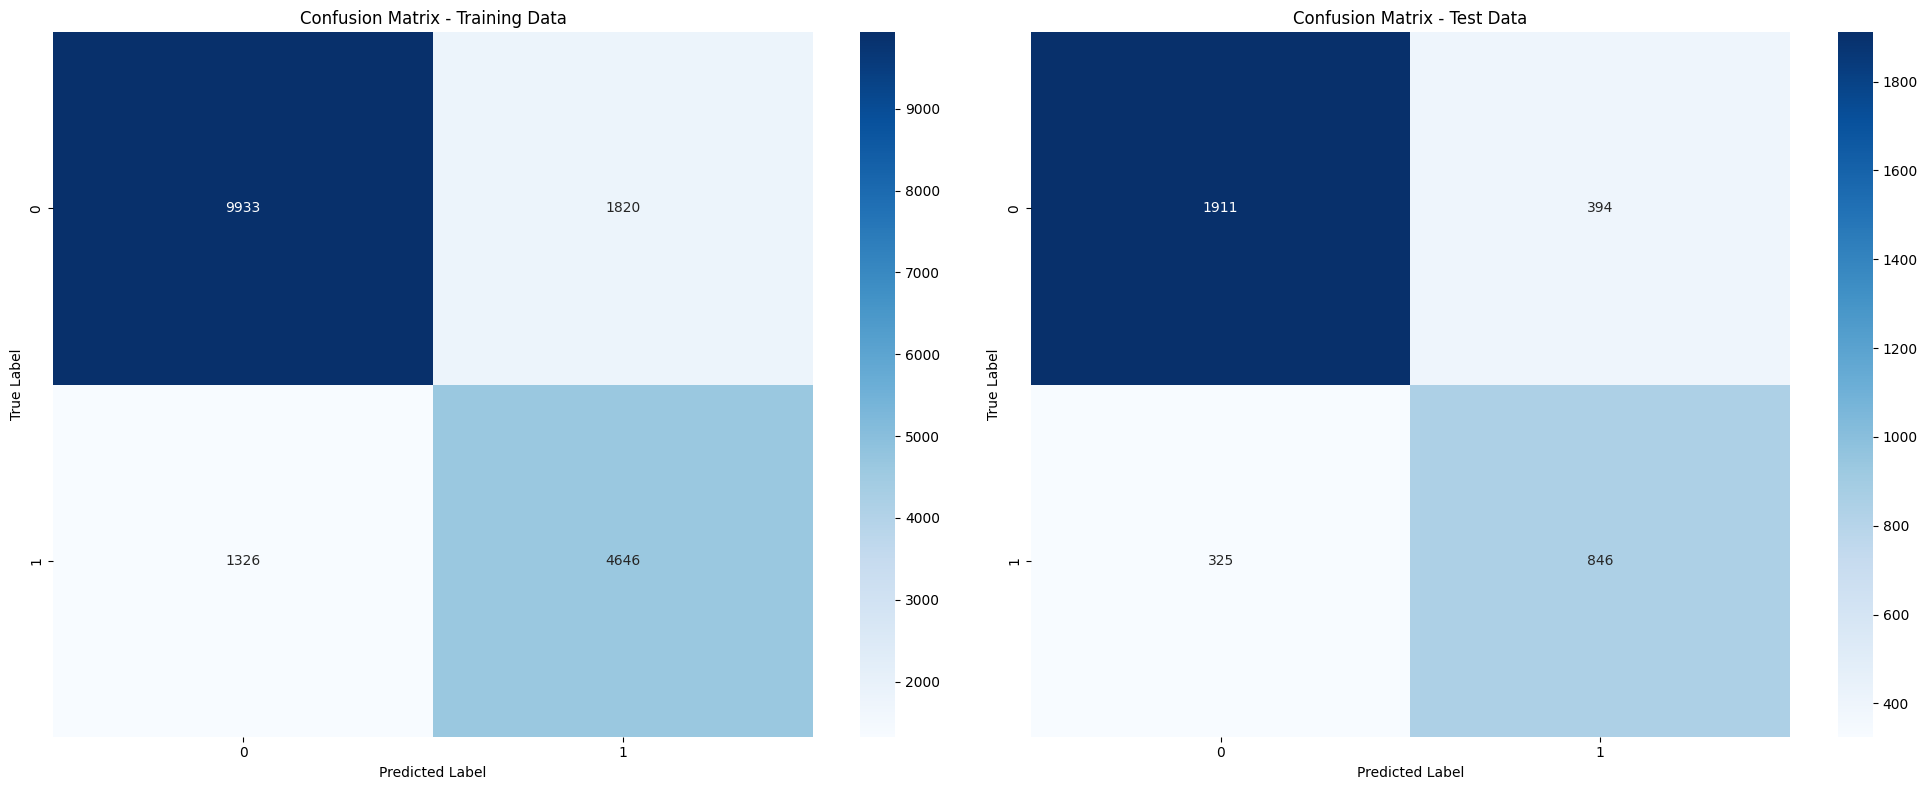

In [59]:
# Generate the confusion matrices
cm_train_lstm = confusion_matrix(y_train, y_pred_train_lstm)
cm_test_lstm = confusion_matrix(y_test, y_pred_test_lstm)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot confusion matrix for the training data
sns.heatmap(cm_train_lstm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_title('Confusion Matrix - Training Data')

# Plot confusion matrix for the test data
sns.heatmap(cm_test_lstm, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_title('Confusion Matrix - Test Data')

# Display the plots
plt.tight_layout()
plt.show()

The confusion matrices for the airline review model illustrate how well it distinguishes between recommended (1) and not recommended (0) reviews:

- **Training Data**:
  - The model correctly identified **9933** non-recommended reviews but misclassified **1820** as recommended.
  - It accurately recognized **4646** recommended reviews, though **1326** were incorrectly labeled as not recommended.
  - This performance indicates that the model is relatively balanced in recognizing both recommended and non-recommended reviews, but there are still notable instances of misclassification.

- **Test Data**:
  - For non-recommended reviews, the model correctly identified **1911** cases but misclassified **394** as recommended.
  - It successfully labeled **846** reviews as recommended, with **325** misclassified as non-recommended.
  - The test data shows a higher rate of misclassification compared to the training data, suggesting potential issues with generalization on unseen data.

These results show a competent ability to classify airline reviews based on recommendations, but the model still have some rooms for improvement.

#### **2. Logistic Regression**

##### **i. Model Definition**

The logistic regression model also uses the embedding layer provided by Keras.

In [60]:
# Clear Session
seed = 20
tf.keras.backend.clear_session()
tf.random.set_seed(seed)

In [61]:
# Define the logistic regression model architecture
model_logreg = Sequential()

# Add embedding layer
model_lstm.add(hub_layer)

# Output layer
model_logreg.add(Dense(2, activation='sigmoid', input_shape=(128,)))

# Compile the model
model_logreg.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model_logreg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               112461824 
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 112462082 (429.01 MB)
Trainable params: 258 (1.01 KB)
Non-trainable params: 112461824 (429.01 MB)
_________________________________________________________________


The model utilizes a pre-trained embedding layer from TensorFlow Hub and reshapes the input to (128, 1). It then employs a dense layer with **2** units and a sigmoid activation function for binary classification, distinguishing between `yes` and `no`.

Like the previous model, this one is compiled with binary cross-entropy loss, uses the Adam optimizer, and tracks accuracy as a metric. The summary provides detailed layer configurations and parameter counts, totaling **112,462,082** parameters, which is quite close to the parameter count of the previous model.

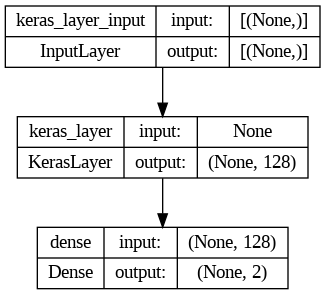

In [62]:
# Plot Layers
tf.keras.utils.plot_model(model_logreg, show_shapes=True)

The diagram above illustrates the architecture of the Logistic Regression model, which is significantly simpler compared to the LSTM model.

##### **ii. Model Training**

The model is trained using `model_logreg` for **100** epochs this time. The validation set is utilized to monitor the model's performance, and the EarlyStopping and LearningRateScheduler callbacks are once again applied effectively.

In [63]:
# Training with Logistic Regression model
%%time
model_logreg_hist = model_logreg.fit(X_train, y_train_ohe, epochs=100, validation_data=(X_val, y_val_ohe), callbacks=[lr_callback, early_stopping])

Epoch 1/100
554/554 [==============================] - 5s 7ms/step - loss: 0.5913 - accuracy: 0.6653 - val_loss: 0.5449 - val_accuracy: 0.6980 - lr: 0.0010
Epoch 2/100
554/554 [==============================] - 2s 4ms/step - loss: 0.5260 - accuracy: 0.7226 - val_loss: 0.4986 - val_accuracy: 0.7629 - lr: 0.0010
Epoch 3/100
554/554 [==============================] - 2s 4ms/step - loss: 0.4941 - accuracy: 0.7565 - val_loss: 0.4723 - val_accuracy: 0.7883 - lr: 0.0010
Epoch 4/100
554/554 [==============================] - 2s 4ms/step - loss: 0.4745 - accuracy: 0.7714 - val_loss: 0.4548 - val_accuracy: 0.7964 - lr: 0.0010
Epoch 5/100
554/554 [==============================] - 2s 4ms/step - loss: 0.4611 - accuracy: 0.7806 - val_loss: 0.4432 - val_accuracy: 0.8086 - lr: 0.0010
Epoch 6/100
554/554 [==============================] - 5s 9ms/step - loss: 0.4513 - accuracy: 0.7880 - val_loss: 0.4337 - val_accuracy: 0.8076 - lr: 0.0010
Epoch 7/100
554/554 [==============================] - 4s 7ms/st

The training process lasted for **100** epochs, taking roughly **4 minutes and 22 seconds** to finish. The final scores for the model were a training loss of **0.4061**, training accuracy of **0.8182**, validation loss of **0.3935**, and validation accuracy of **0.8244**.

The model demonstrates a **good fit** on the dataset, achieving **nearly the same accuracy** as the previous model that trained for about an hour, but in **just 4 minutes**.

##### **iii. Model Evaluation**

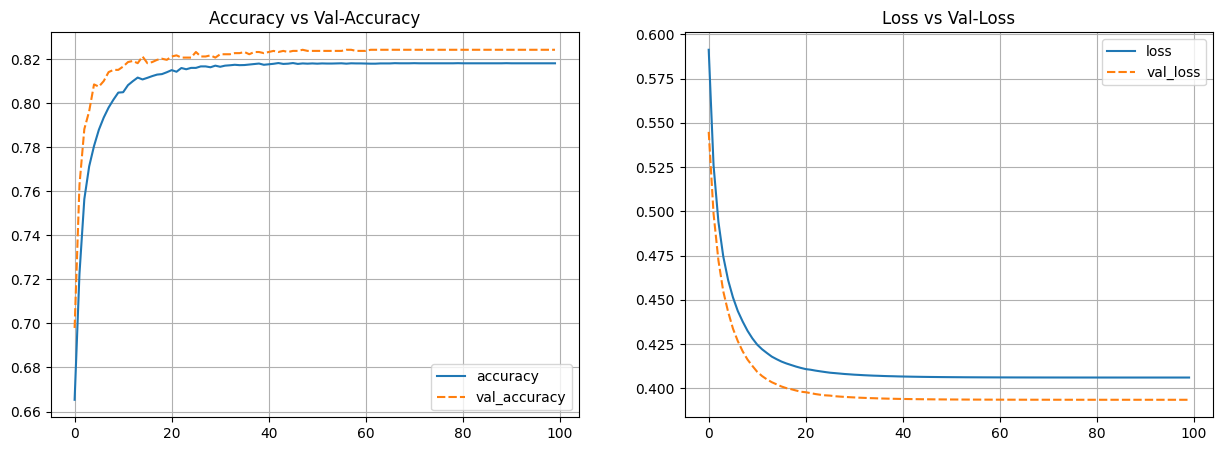

In [64]:
# Plot Training Results
model_logreg_hist_df = pd.DataFrame(model_logreg_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_logreg_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_logreg_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

These are the key insights from the graphs for accuracy and loss that demonstrate the performance of Logistic Regression model over 100 epochs:

- **Accuracy vs Validation Accuracy**:
   - Both training and validation accuracy increase sharply in the initial epochs and then plateau around 82%, indicating that the model quickly reaches its optimal performance and maintains it.
   - The close alignment between training and validation accuracy throughout the training process suggests that the model generalizes well to new, unseen data without significant overfitting.

- **Loss vs Validation Loss**:
   - Both loss metrics decrease steeply initially before flattening out, which is typical as the model approaches an optimal state. The training and validation loss both stabilize at low values, close to 0.40.
   - This consistency between the training and validation loss further supports the model's effective generalization.

**Comparison to Previous Insights**:

Compared to the previous insights from the LSTM model where there were fluctuations and disparities between training and validation metrics, this current model exhibits more stable and aligned performance metrics. Previously, there might have been concerns about overfitting or underfitting based on how the validation metrics lagged behind or diverged from the training metrics. In this current setup, the more consistent and parallel trends between training and validation results indicate that the model is likely well-tuned and robust, with improvements in handling the generalization compared to previous iterations. This is evident from the plateauing of both accuracy and loss graphs, suggesting an effective learning and prediction process without the need for further significant adjustments to avoid overfitting.

In [65]:
# Predict probabilities for each class
y_pred_train_probs_logreg = model_logreg.predict(X_train)

# Get the predicted class labels (argmax along the last axis)
y_pred_train_logreg = np.argmax(y_pred_train_probs_logreg, axis=1)

# Classification report
print(classification_report(y_train, y_pred_train_logreg))

554/554 [==============================] - 2s 3ms/step
              precision    recall  f1-score   support

           0       0.84      0.89      0.87     11753
           1       0.76      0.67      0.71      5972

    accuracy                           0.82     17725
   macro avg       0.80      0.78      0.79     17725
weighted avg       0.81      0.82      0.82     17725



In [66]:
# Predict probabilities for each class
y_pred_test_probs_logreg = model_logreg.predict(X_test)

# Get the predicted class labels
y_pred_test_logreg = np.argmax(y_pred_test_probs_logreg, axis=1)

# Classification report
print(classification_report(y_test, y_pred_test_logreg))

109/109 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      2305
           1       0.74      0.63      0.68      1171

    accuracy                           0.80      3476
   macro avg       0.78      0.76      0.77      3476
weighted avg       0.80      0.80      0.80      3476



The performance metrics for the model on training and test data shows solid classification capabilities, with slight variations between the two:

- **Training Data Performance**:
   - The model achieves an overall accuracy of 82%. It shows higher effectiveness in classifying non-recommended reviews (class 0) with a precision of 0.84 and a recall of 0.89. Recommended reviews (class 1) have lower precision and recall, at 0.76 and 0.67 respectively, suggesting challenges in accurately classifying positive recommendations.

- **Test Data Performance**:
   - On the test set, the model records an accuracy of 80%, slightly lower than the training data. The precision and recall for non-recommended reviews remain high, similar to the training data, while the scores for recommended reviews drop slightly, indicating a persistent issue with classifying positive feedback under varied data conditions.

Overall, the model is more reliable in identifying non-recommended reviews across both datasets. It maintains consistent accuracy but struggles slightly more with positively recommended reviews, especially when generalizing from training to unseen test data.

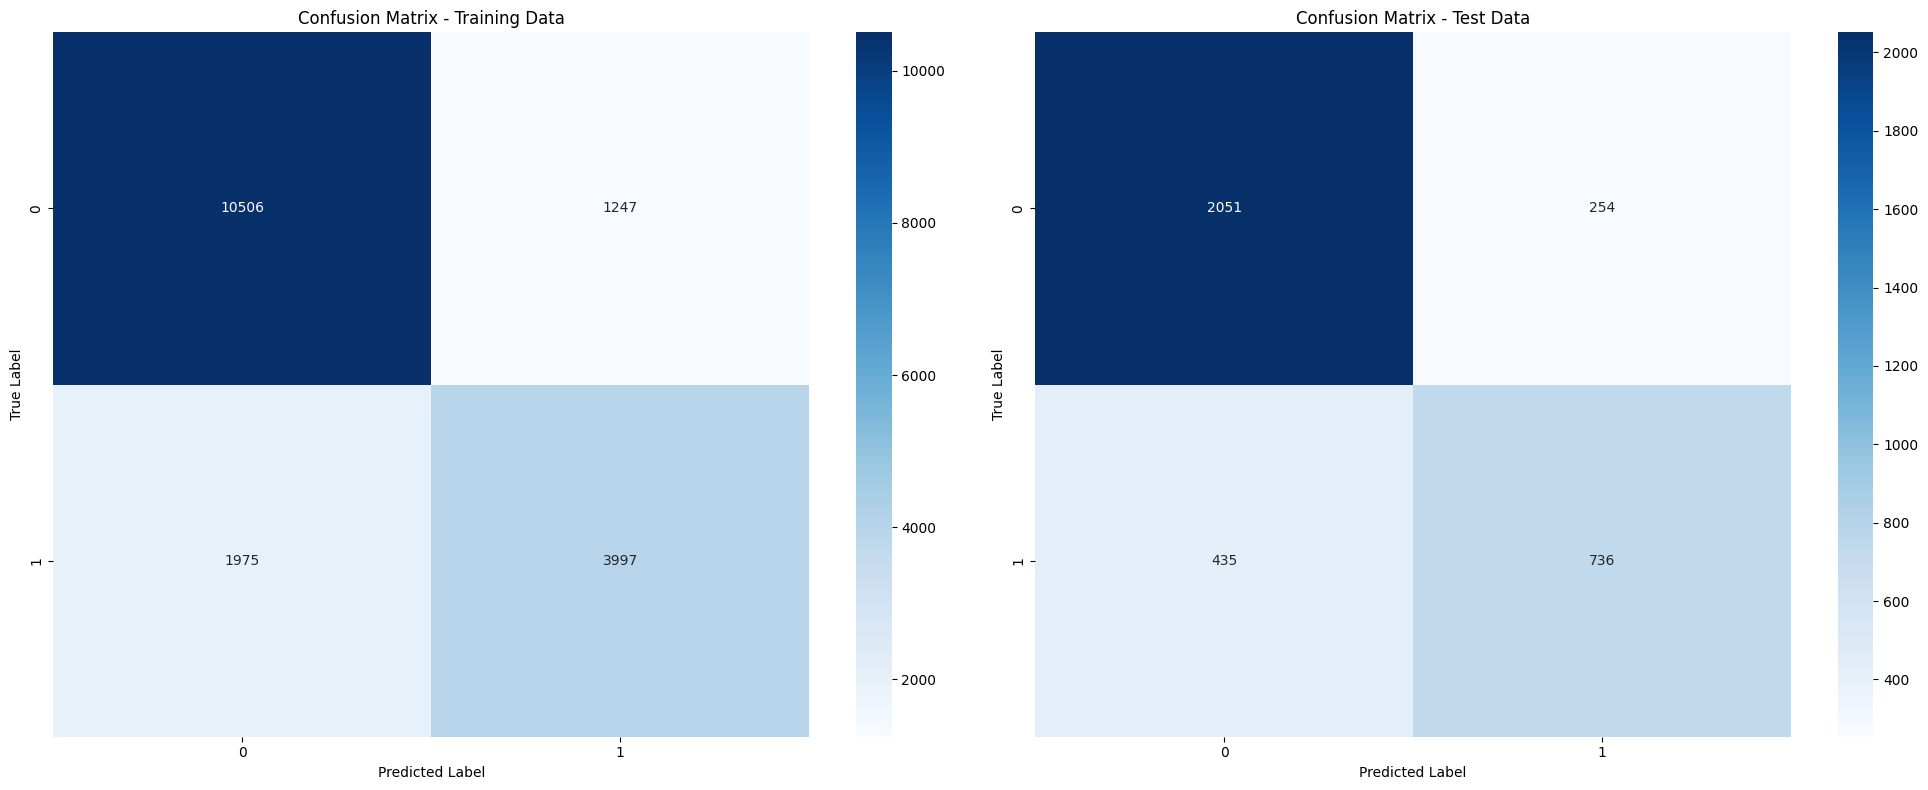

In [67]:
# Generate the confusion matrices
cm_train_logreg = confusion_matrix(y_train, y_pred_train_logreg)
cm_test_logreg = confusion_matrix(y_test, y_pred_test_logreg)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot confusion matrix for the training data
sns.heatmap(cm_train_logreg, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_title('Confusion Matrix - Training Data')

# Plot confusion matrix for the test data
sns.heatmap(cm_test_logreg, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_title('Confusion Matrix - Test Data')

# Display the plots
plt.tight_layout()
plt.show()

The confusion matrices for training and test data using Logistic Regression model:

- **Training Data**:
   - The model correctly identified **10506** non-recommended reviews but misclassified **1247** as recommended.
   - For recommended reviews, it accurately predicted **3997** cases and incorrectly classified **1975** as non-recommended.
   - This data shows a stronger ability to correctly identify non-recommended reviews compared to recommended ones, with a noticeable number of false negatives.

- **Test Data**:
   - The model accurately predicted **2051** non-recommended reviews, with **254** incorrectly marked as recommended.
   - It correctly identified **736** recommended reviews, but misclassified **435** as non-recommended.
   - The test data mirrors the training results, showing a similar trend of better identification of non-recommended reviews but a higher rate of misclassifying recommended reviews.

These results indicate that the model is generally more effective at identifying non-recommended reviews while facing challenges in accurately classifying recommended reviews, as seen by the higher numbers of false negatives.

### **G. Model Saving**

The conclusion drawn from both models suggests that the **logistic regression model is superior** due to its ability to achieve higher accuracy in a significantly shorter training time. As a result, the logistic regression model will be the one saved for future use.

In [68]:
# Model summary
model_logreg.trainable = False
model_logreg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               112461824 
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 112462082 (429.01 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 112462082 (429.01 MB)
_________________________________________________________________


In [69]:
# Save the model
model_logreg.save('model_logreg')

# Directory name of the model name
model_dir = 'model_logreg'

# Save model as tensorflow model
model_logreg.save(model_dir, save_format = 'tf')

In [70]:
# Compress the folder
!zip -r model_logreg.zip model_logreg

# Download the compressed folder
files.download('model_logreg.zip')

  adding: model_logreg/ (stored 0%)
  adding: model_logreg/variables/ (stored 0%)
  adding: model_logreg/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: model_logreg/variables/variables.index (deflated 53%)
  adding: model_logreg/saved_model.pb (deflated 83%)
  adding: model_logreg/fingerprint.pb (stored 0%)
  adding: model_logreg/keras_metadata.pb (deflated 81%)
  adding: model_logreg/assets/ (stored 0%)
  adding: model_logreg/assets/tokens.txt (deflated 51%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The model has been successfully saved in a ZIP format and can now be utilized in other analyses.

### **H. Model Inference**

This section will be performed in a separate file named **'final_project_NLP_inference.ipynb'**.

### **I. Analysis**

#### **i. EDA**

- **Review Word Cloud**: The word clouds highlight common themes in passenger reviews, with **positive** sentiments emphasizing **good service and satisfaction**, and **negative** sentiments focusing on **operational inefficiencies and poor customer experiences**.

- **Verified User Distribution**: The dataset displays a balanced proportion of reviews from verified and non-verified users, where the inclusion of verified reviews could contribute to increased credibility and reliability of the dataset and its findings.

- **Type of Traveller Distribution**: The dataset indicates that **solo leisure travelers** provide the most reviews and tend to give more negative recommendations for the airline, highlighting a notable trend of dissatisfaction within this group of travelers.

- **Seat Type Distribution**: The analysis highlights varying levels of satisfaction across different airline seating classes, with premium classes like **First Class** and **Business Class** generally giving more **positive** feedback compared to **Economy** and **Premium Economy**, suggesting differing levels of service and amenities that impact customer satisfaction.

- **Rating Distribution**: The analysis of passenger ratings across different airline amenities shows a mix of satisfaction and dissatisfaction. Areas like **seat comfort, WiFi connectivity**, and the **perceived value for money** stand out as crucial aspects that could significantly impact the overall passenger experience and warrant improvements.

- **Rating Correlation Analysis**: Improving seat comfort and integrated service quality, especially in cabin staff service, food and beverages, and ground service, could notably enhance overall passenger satisfaction.

- **Recommended Distribution**: The distribution of recommendations based on airline reviews indicates a significant challenge for the airline in improving passenger satisfaction, with a notable **majority of passengers not recommeding** their services.

#### **ii. Model Evaluation**

- **Best Model**: The best model is the **sequential Logistic Regression** architecture, based on their training, validation, and testing scores. The model is better because it efficiently handles the linearity in the relationship between features and the target variable, which is ideal for cases like sentiment analysis where dependencies can be directly mapped from input features.

- **Training vs Validation**: The model shows a good fit between training and validation loss and accuracy, suggesting it has learned the underlying patterns without memorizing the training data specifics, which can often lead to overfitting.

- **Metrics Evaluation**:
  - **Training Set**: The training set scores 0.82 for accuracy, indicating that the model is capable of correctly identifying the majority of the labels from the data it was trained on.
  - **Testing Set**: The testing set scores 0.80 for accuracy, which is slightly lower than the training set but still indicates good generalization to unseen data.
  - **Model Fit**: The model represents a good fit between the training set and testing set, demonstrating that it generalizes well without significant overfitting.

- **Prediction Capability**: The model can effectively classify the positive and negative reviews given by reviewers, making it a useful tool for understanding reviewers sentiments and preferences.

- **Missclassification**: The model is generally more effective at identifying non-recommended reviews while facing challenges in accurately classifying recommended reviews, as seen by the higher numbers of false negatives. This might be due to fewer instances of positive examples in the training data or less distinguishable features in positive reviews.

- **Model Advantages**:
  - **Scalability**: Logistic regression is computationally inexpensive to train, making it scalable for larger datasets.
  - **Interpretability**: As a linear model, it offers great interpretability, allowing insights into the impact of different features on the prediction outcome.
  - **Speed**: Fast to train and predict, suitable for real-time analysis.

- **Model Disadvantages**:
  - **Linear Boundary**: The primary limitation is its assumption of linearity between the dependent variable and the independent variables. It may not capture complex patterns in data as effectively as non-linear models.
  - **Feature Sensitivity**: Logistic regression can be highly sensitive to unbalanced data and outliers, which can skew the results unless properly preprocessed.
  - **Limited Complexity**: While it's efficient and interpretable, logistic regression may not perform well with complex relationships that better suit models like neural networks or ensemble methods.

#### **iii. Model Improvement**

- **Advanced Transfer Learning Models**: Consider exploring advanced pre-trained models like **BERT** or **GPT** for generating embeddings. These models offer contextually enriched embeddings that capture detailed semantic meanings, which could potentially result in significant enhancements in sentiment analysis accuracy.

- **Enhanced Text Representations**: Move beyond basic embeddings and vectorizations by implementing **TF-IDF (Term Frequency-Inverse Document Frequency)** in conjunction with **SVD (Singular Value Decomposition)**. This approach helps in reducing feature space dimensionality while retaining the most informative text features, which can lead to more accurate predictions.

- **Address Class Imbalance**: Implement strategies to manage class imbalance, which can skew model training and lead to biased predictions. Techniques such as **Synthetic Minority Over-sampling Technique (SMOTE)** or tailored data sampling can help balance the dataset and improve the model's performance across different classes.

- **Advanced Tokenization Techniques**: Utilize advanced tokenization methods like **n-grams**, which capture not only single words but also phrases and contextual relationships, enhancing the feature set for training the model.

- **Use of Diverse Metrics**: Expand the evaluation criteria by including more metrics besides accuracy, like F1-score, precision, recall, and AUC-ROC. These metrics offer a more complete understanding of model performance, especially in effectively managing predictions for both positive and negative classes

#### **iv. Bussiness Insights**

Here are the critical business insights that can be inferred from this Airline Sentiment Analysis:

- **Enhancing Customer Experience**: Accurate sentiment analysis enables airlines to make proactive adjustments in areas frequently criticized by passengers. This can involve training enhancements, policy revisions, or upgrades to in-flight amenities, boosting overall customer satisfaction and loyalty.

- **Targeted Marketing and Personalization**: Insights from customer feedback allow for more precise marketing efforts. Airlines can tailor promotions and communications to address specific preferences and grievances, enhancing customer engagement and trust.

- **Operational Efficiency**: Sentiment analysis informs better resource allocation, directing investments into areas that significantly impact passenger satisfaction. This strategic focus ensures optimal use of resources, enhancing service where it matters most.

- **Risk Management**: Early identification of negative trends in customer feedback can prevent larger issues, allowing airlines to act swiftly to protect their reputation and avoid potential losses.

- **Data-Driven Decision Making**: Detailed analysis from sentiment models provides decision-makers with actionable insights, leading to more informed and effective strategic decisions.

### **J. Conclusion**

The **Logistic Regression** model with pre-trained embedding layer effectively performs **Natural Language Processing (NLP)** tasks by categorizing airline reviews into positive (recommended) and negative (not recommended) sentiments. This achievement aligns seamlessly with FlightBuddy's objective of enhancing decision-making for travelers through insightful review analysis.